In [1]:
import math
from itertools import product
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [2]:
def value_iteration(threshold, env, rewards, discount=0.01):
    V = torch.zeros(env.n_states, dtype=torch.float32)
    delta = np.inf
    
    while delta > threshold:
        delta = 0
        for s in range(env.n_states):
            max_v = torch.tensor([-float('inf')])
            for a in range(env.n_actions):
                probs = torch.from_numpy(env.dynamics[:, a, s]).float()
                max_v = torch.maximum(max_v, torch.dot(probs, rewards + discount * V))
            delta = max(delta, torch.abs(V[s] - max_v).numpy())
            V[s] = max_v

    policy = torch.zeros((env.n_states, env.n_actions), dtype=torch.float32)
    for s in range(env.n_states):
        for a in range(env.n_actions):
            probs = torch.from_numpy(env.dynamics[:, a, s]).float()
            policy[s, a] = torch.dot(probs, rewards + discount * V)

    policy = policy - policy.max(dim=1, keepdims=True)[0]
    exps = torch.exp(policy)
    policy = exps / exps.sum(dim=1, keepdims=True)
    return policy

In [3]:
class WorldObject(object):
    def __init__(self, inner_color, outer_color):
        self.inner_color = inner_color
        self.outer_color = outer_color

In [4]:
class Objectworld:
    def __init__(self, grid_size, n_objects, n_colors, wind, discount):
        self.wind = float(wind)
        self.grid_size = grid_size
        self.actions = ((1, 0), (0, 1), (-1, 0), (0, -1), (0, 0))
        self.n_actions = len(self.actions)
        self.n_states = grid_size**2
        self.n_objects = n_objects
        self.n_colors = n_colors
        self.discount = discount

        self.objects = {}
        for _ in range(self.n_objects):
            obj = WorldObject(np.random.randint(self.n_colors), 
                              np.random.randint(self.n_colors))
            while True:
                x = np.random.randint(self.grid_size)
                y = np.random.randint(self.grid_size)

                if (x, y) not in self.objects:
                    break
            self.objects[x, y] = obj

        self.dynamics = self.transition_probabilities()
        self.real_rewards = np.array([self.reward(s) for s in range(self.n_states)])
            

    def feature_vector(self, state, discrete=True):
        x_s, y_s = state%self.grid_size, state//self.grid_size

        nearest_inner = {}
        nearest_outer = {}

        for y in range(self.grid_size):
            for x in range(self.grid_size):
                if (x, y) in self.objects:
                    dist = math.hypot((x - x_s), (y - y_s))
                    obj = self.objects[x, y]
                    if obj.inner_color in nearest_inner:
                        if dist < nearest_inner[obj.inner_color]:
                            nearest_inner[obj.inner_color] = dist
                    else:
                        nearest_inner[obj.inner_color] = dist
                    if obj.outer_color in nearest_outer:
                        if dist < nearest_outer[obj.outer_color]:
                            nearest_outer[obj.outer_color] = dist
                    else:
                        nearest_outer[obj.outer_color] = dist

        for c in range(self.n_colors):
            if c not in nearest_inner:
                nearest_inner[c] = 0
            if c not in nearest_outer:
                nearest_outer[c] = 0

        if discrete:
            state = np.zeros((2*self.n_colors*self.grid_size,))
            i = 0
            for c in range(self.n_colors):
                for d in range(1, self.grid_size+1):
                    if nearest_inner[c] < d:
                        state[i] = 1
                    i += 1
                    if nearest_outer[c] < d:
                        state[i] = 1
                    i += 1
        else:
            state = np.zeros((2*self.n_colors))
            i = 0
            for c in range(self.n_colors):
                state[i] = nearest_inner[c]
                i += 1
                state[i] = nearest_outer[c]
                i += 1

        return state


    def feature_matrix(self, discrete=True):
        return np.array([self.feature_vector(i, discrete)
                         for i in range(self.n_states)])


    def reward(self, state_p):
        x, y = state_p%self.grid_size, state_p//self.grid_size

        near_c0 = False
        near_c1 = False
        for (dx, dy) in product(range(-3, 4), range(-3, 4)):
            if 0 <= x + dx < self.grid_size and 0 <= y + dy < self.grid_size:
                if (abs(dx) + abs(dy) <= 3 and
                        (x+dx, y+dy) in self.objects and
                        self.objects[x+dx, y+dy].outer_color == 0):
                    near_c0 = True
                if (abs(dx) + abs(dy) <= 2 and
                        (x+dx, y+dy) in self.objects and
                        self.objects[x+dx, y+dy].outer_color == 1):
                    near_c1 = True
        if near_c0 and near_c1:
            return 1
        if near_c0:
            return -1
        return 0
        

    def reset(self, random=False):
        if random:
            self.state = np.random.randint(self.n_states)
        else:
            self.state = 0
        return self.state


    def step(self, a):
        probs = self.dynamics[:, a, self.state]
        self.state = np.random.choice(self.n_states, p=probs)
        return self.state


    def transition_probabilities(self):
        dynamics = np.zeros((self.n_states, self.n_actions, self.n_states))
        # S_t+1, A_t, S_t
        for s in range(self.n_states):
            x, y = s%self.grid_size, s//self.grid_size
            for a in range(self.n_actions):
                x_a, y_a = self.actions[a]
                for d in range(self.n_actions):
                    x_d, y_d = self.actions[d]
                    if 0 <= x+x_d < self.grid_size and 0 <= y+y_d < self.grid_size:
                        dynamics[(x+x_d) + (y+y_d)*self.grid_size, a, s] += self.wind/self.n_actions
                    else:
                        dynamics[s, a, s] += self.wind/self.n_actions
                if 0 <= x+x_a < self.grid_size and 0 <= y+y_a < self.grid_size:
                    dynamics[(x+x_a) + (y+y_a)*self.grid_size, a, s] += 1 - self.wind
                else:
                    dynamics[s, a, s] += 1 - self.wind
                
        return dynamics


    def optimal_policy(self):
        real_rewards = torch.tensor([self.reward(s) for s in range(self.n_states)], dtype=torch.float32)
        policy = value_iteration(0.0001, self, real_rewards, self.discount)
        return policy.argmax(1)


    def generate_trajectories(self, num, length, policy=None):
        if not policy:
            policy = self.optimal_policy()

        trajs = []
        for n in range(num):
            t = []
            state = self.reset(random=True)
            for i in range(length):
                action = policy[state]
                state_p = self.step(action)
                t.append([state, action, self.reward(state_p)])
                state = state_p
            trajs.append(t)
        return np.array(trajs)

In [122]:
# class GridWorld:
#     def __init__(self, grid_size=5, wind=0.2):
#         # (0,0) bottom left corner (x,y)
#         self.names = ["Right", "Down", "Left", "Up"]
#         self.actions = [(1,0),(0,1),(-1,0),(0,-1)]
#         self.n_actions = len(self.actions)
#         self.n_states = grid_size**2
#         self.wind = float(wind)
        
#         self.grid_size = grid_size
#         self.grid = np.zeros((grid_size, grid_size))

#         self.features = np.eye(self.n_states)
#         self.dynamics = self.transition_probabilities()
#         self.real_rewards = np.array([self.reward(s) for s in range(self.n_states)])
#         self.state = 0


#     def reward(self, state_p):
#         return 1 if state_p == self.n_states-1 else 0
        

#     def reset(self, random=False):
#         if random:
#             self.state = np.random.randint(self.n_states)
#         else:
#             self.state = 0
#         return self.state


#     def step(self, a):
#         probs = self.dynamics[:, a, self.state]
#         self.state = np.random.choice(self.n_states, p=probs)
#         return self.state


#     def transition_probabilities(self):
#         dynamics = np.zeros((self.n_states, self.n_actions, self.n_states))
#         # S_t+1, A_t, S_t
#         for s in range(self.n_states):
#             x, y = s%self.grid_size, s//self.grid_size
#             for a in range(self.n_actions):
#                 x_a, y_a = self.actions[a]
#                 for d in range(self.n_actions):
#                     x_d, y_d = self.actions[d]
#                     if 0 <= x+x_d < self.grid_size and 0 <= y+y_d < self.grid_size:
#                         dynamics[(x+x_d) + (y+y_d)*self.grid_size, a, s] += self.wind/self.n_actions
#                     else:
#                         dynamics[s, a, s] += self.wind/self.n_actions
#                 if 0 <= x+x_a < self.grid_size and 0 <= y+y_a < self.grid_size:
#                     dynamics[(x+x_a) + (y+y_a)*self.grid_size, a, s] += 1 - self.wind
#                 else:
#                     dynamics[s, a, s] += 1 - self.wind
                
#         return dynamics

    
#     def test(self):
#         for s in range(self.n_states):
#             print("/// State: ", s)
#             for a in range(self.n_actions):
#                 print("/// Action: ", self.names[a])
#                 probs = self.dynamics[:, a, s]
#                 print(probs.reshape(-1, self.grid_size))


#     def optimal_policy(self, state):
#         x, y = state%self.grid_size, state//self.grid_size
#         if x > y:
#             return 1
#         elif x < y:
#             return 0
#         else:
#             return np.random.randint(2)


#     def generate_trajectories(self, num, length, policy=None):
#         if not policy:
#             policy = self.optimal_policy

#         trajs = []
#         for n in range(num):
#             t = []
#             state = self.reset()
#             for i in range(length):
#                 action = policy(state)
#                 state_p = self.step(action)
#                 t.append([state, action])
#                 state = state_p
#             trajs.append(t)
#         return np.array(trajs)

In [16]:
grid_size = 10
n_objects = 10
n_colors = 2
wind = 0.3
discount = 0.9

num_trajectories, len_trajectory = 500, 30
n_epochs = 500
lr = 0.005

In [17]:
ow = Objectworld(grid_size, n_objects, n_colors, wind, discount)
trajectories = ow.generate_trajectories(num_trajectories, len_trajectory)
features = ow.feature_matrix(discrete=False)

In [11]:
# gw = GridWorld(grid_size, wind)
# trajectories = gw.generate_trajectories(num_trajectories, len_trajectory)
# features = np.eye(gw.n_states)

In [18]:
class DeepMaximumEntropy:
    def __init__(self, env, trajectories, features, layers=(8, 16), lr=0.001, discount=0.9):
        self.env = env
        self.trajectories = trajectories
        self.features = torch.from_numpy(features).float()
        self.discount = discount
        self.dynamics = torch.from_numpy(self.env.dynamics).float()

        self.rews = []
        self.net = []
        last = features.shape[1]
        for l in layers:
            self.net.append(nn.Linear(last, l))
            self.net.append(nn.ReLU())
            last = l
        self.net.append(nn.Linear(last, 1))
        self.net.append(nn.Tanh())
        self.net = nn.Sequential(*self.net)
        self.optim = torch.optim.Adagrad(self.net.parameters(), lr)


    def get_rewards(self):
        return self.rews
        

    def forward(self, features):
        x = self.net(features)
        # return (x - x.mean()) / x.std()
        return x

    # old way for computing esv
    # def expected_state_visitation_frequency(self, policy):
    #     # probability of visiting the initial state
    #     prob_initial_state = torch.zeros(self.env.n_states)
    #     for traj in self.trajectories:
    #         prob_initial_state[traj[0, 0]] += 1.0
    #     prob_initial_state = prob_initial_state / self.trajectories.shape[0]
    #     # Compute 𝜇
    #     mu = prob_initial_state.repeat(self.trajectories.shape[1], 1)
    #     for t in range(1, self.trajectories.shape[1]):
    #         mu[t, :] = 0
    #         for s in range(self.env.n_states):
    #             for a in range(self.env.n_actions):
    #                 for s_p in range(self.env.n_states):
    #                     mu[t, s] += mu[t-1, s_p] * policy[s_p, a] * self.dynamics[s_p, a, s]
    #     return mu.sum(dim=0)


    #fast method
    def expected_state_visitation_frequency(self, policy):
        # probability of visiting the initial state
        prob_initial_state = torch.zeros(self.env.n_states)
        for traj in self.trajectories:
            prob_initial_state[traj[0, 0]] += 1.0
        prob_initial_state = prob_initial_state / self.trajectories.shape[0]

        # Compute 𝜇 (pure vectorized :D)
        mu = prob_initial_state.repeat(self.trajectories.shape[1], 1)
        x = (policy[:, :, np.newaxis] * self.dynamics).sum(1)
        for t in range(1, self.trajectories.shape[1]):
            mu[t, :] = mu[t-1, :] @ x

        return mu.sum(dim=0)


    def state_visitation_frequency(self):
        svf = torch.zeros(self.env.n_states, dtype=torch.float32)
        for traj in self.trajectories:
            for s, *_ in traj:
                svf[s] += 1
        return svf / self.trajectories.shape[0]


    def expected_features(self):
        exp_f = torch.zeros_like(self.features[0]).float()
        for traj in self.trajectories:
            for s, *_ in traj:
                exp_f += self.features[s]
        return exp_f / self.trajectories.shape[0]


    def train(self, n_epochs, save_rewards=True, plot=False):            
        self.rews = []
        # exp_f = self.expected_features()
        svf = self.state_visitation_frequency()

        for i in tqdm(range(n_epochs)):
            # with torch.no_grad():
            rewards = self.forward(self.features).flatten()
            if save_rewards:
                self.rews.append(rewards.detach().cpu().numpy())

            policy = value_iteration(0.001, self.env, rewards.detach(), self.discount)
            exp_svf = self.expected_state_visitation_frequency(policy)

            r_grads = svf - exp_svf

            self.optim.zero_grad()
            rewards.backward(-r_grads)
            self.optim.step()

            if plot:
                plt.pcolor(rewards.detach().reshape(self.env.grid_size, self.env.grid_size))
                plt.colorbar()
                plt.show()

        with torch.no_grad():
            rewards = self.forward(self.features)
        return rewards

In [19]:
dme = DeepMaximumEntropy(ow, trajectories, features, (16, 16), lr, discount)

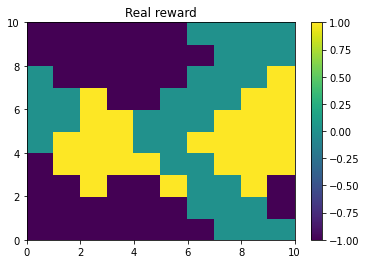

In [20]:
plt.pcolor(ow.real_rewards.reshape(grid_size, grid_size))
plt.colorbar()
plt.title("Real reward")
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

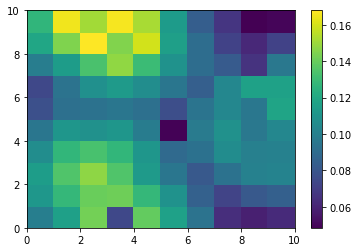

  0%|          | 1/500 [00:00<04:31,  1.84it/s]

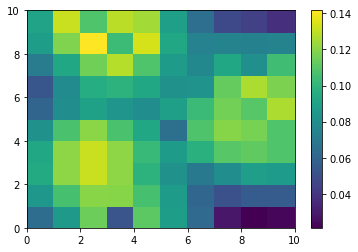

  0%|          | 2/500 [00:01<04:20,  1.91it/s]

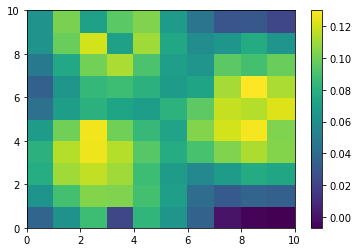

  1%|          | 3/500 [00:01<04:10,  1.98it/s]

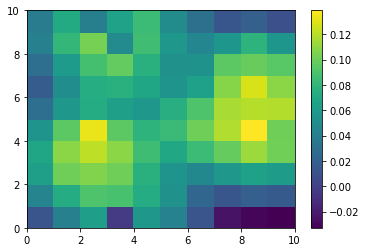

  1%|          | 4/500 [00:02<04:11,  1.97it/s]

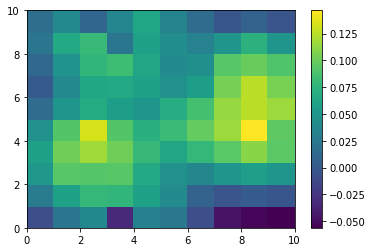

  1%|          | 5/500 [00:02<04:12,  1.96it/s]

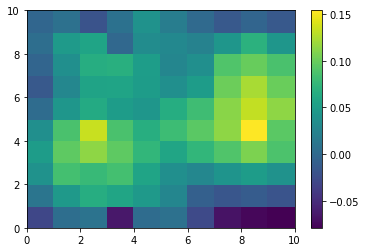

  1%|          | 6/500 [00:03<04:13,  1.95it/s]

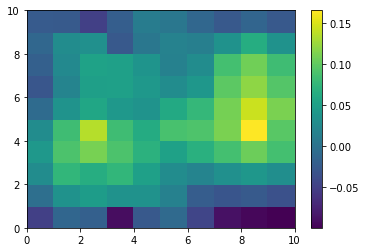

  1%|▏         | 7/500 [00:03<04:29,  1.83it/s]

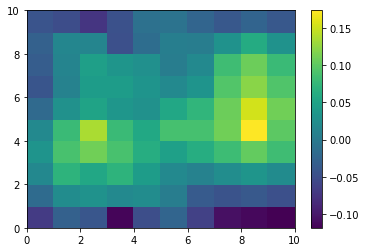

  2%|▏         | 8/500 [00:04<04:26,  1.85it/s]

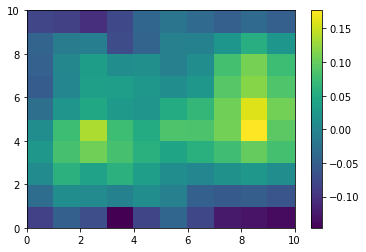

  2%|▏         | 9/500 [00:04<04:21,  1.87it/s]

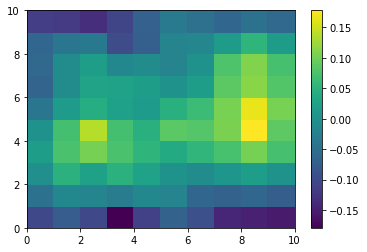

  2%|▏         | 10/500 [00:05<04:22,  1.87it/s]

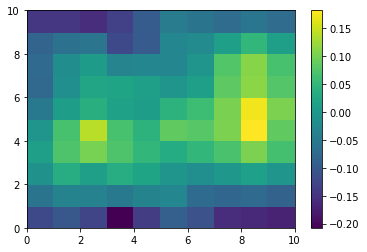

  2%|▏         | 11/500 [00:05<04:20,  1.88it/s]

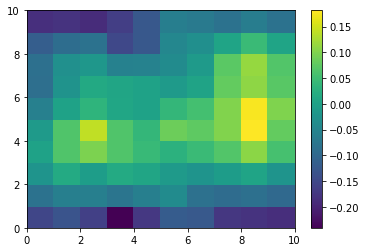

  2%|▏         | 12/500 [00:06<04:20,  1.87it/s]

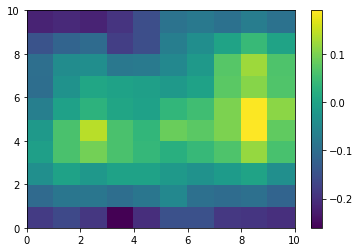

  3%|▎         | 13/500 [00:06<04:20,  1.87it/s]

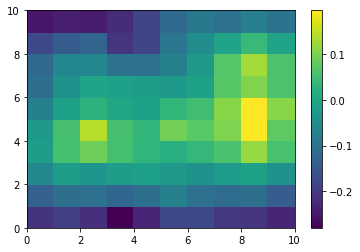

  3%|▎         | 14/500 [00:07<04:20,  1.87it/s]

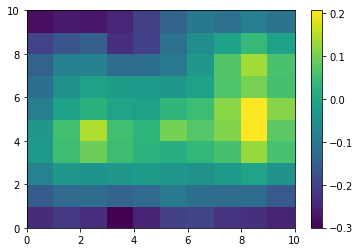

  3%|▎         | 15/500 [00:07<04:18,  1.87it/s]

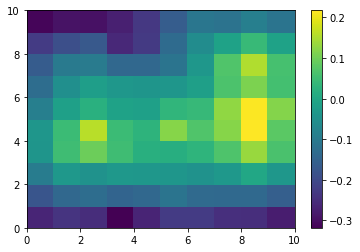

  3%|▎         | 16/500 [00:08<04:19,  1.87it/s]

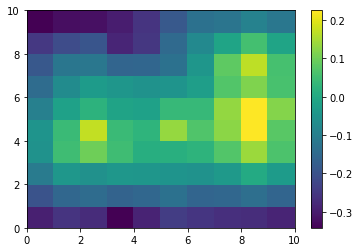

  3%|▎         | 17/500 [00:09<04:20,  1.86it/s]

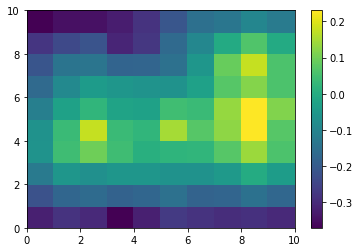

  4%|▎         | 18/500 [00:09<04:40,  1.72it/s]

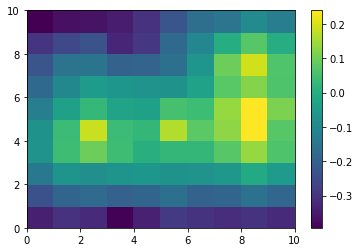

  4%|▍         | 19/500 [00:10<04:36,  1.74it/s]

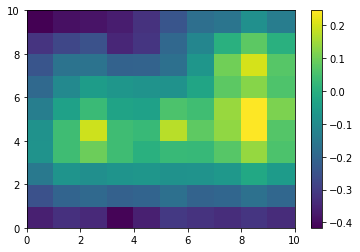

  4%|▍         | 20/500 [00:10<04:34,  1.75it/s]

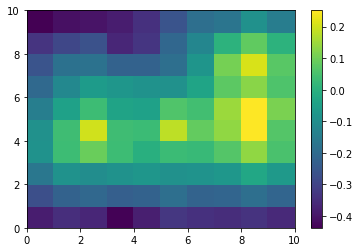

  4%|▍         | 21/500 [00:11<04:32,  1.76it/s]

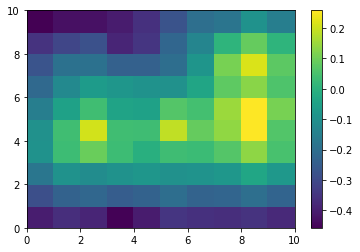

  4%|▍         | 22/500 [00:11<04:28,  1.78it/s]

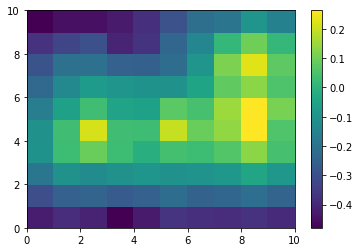

  5%|▍         | 23/500 [00:12<04:28,  1.78it/s]

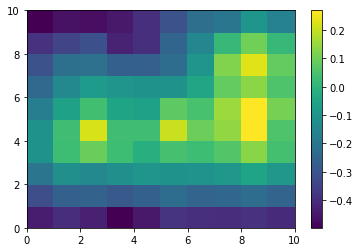

  5%|▍         | 24/500 [00:13<04:29,  1.77it/s]

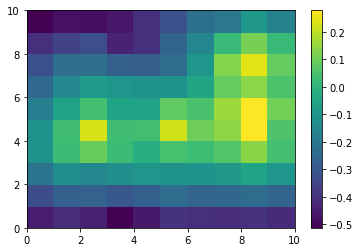

  5%|▌         | 25/500 [00:13<04:34,  1.73it/s]

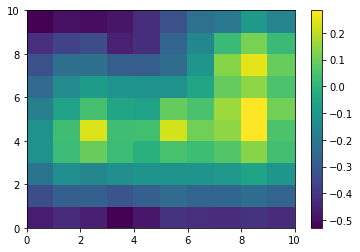

  5%|▌         | 26/500 [00:14<04:32,  1.74it/s]

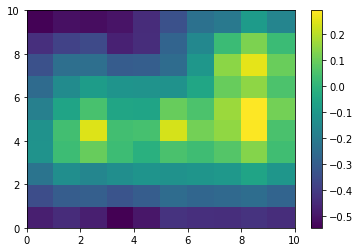

  5%|▌         | 27/500 [00:14<04:33,  1.73it/s]

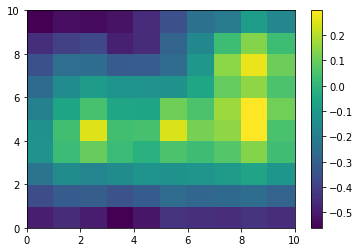

  6%|▌         | 28/500 [00:15<04:51,  1.62it/s]

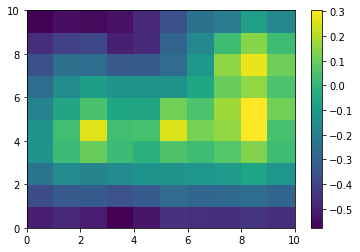

  6%|▌         | 29/500 [00:16<05:45,  1.36it/s]

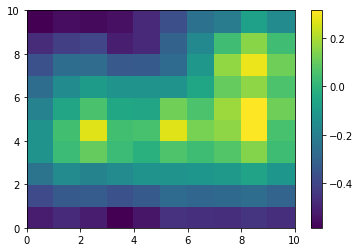

  6%|▌         | 30/500 [00:17<05:30,  1.42it/s]

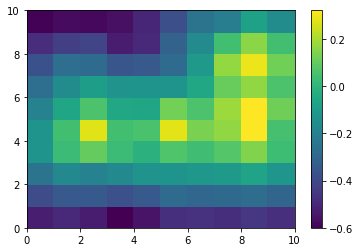

  6%|▌         | 31/500 [00:17<05:16,  1.48it/s]

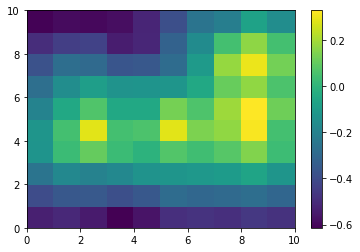

  6%|▋         | 32/500 [00:18<05:04,  1.53it/s]

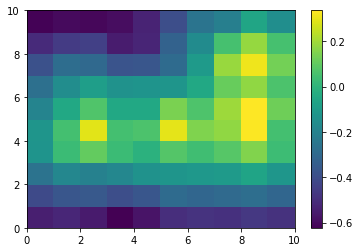

  7%|▋         | 33/500 [00:18<04:55,  1.58it/s]

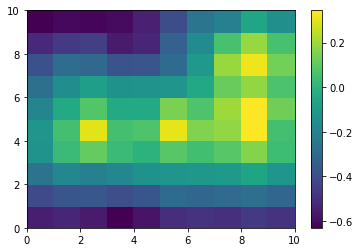

  7%|▋         | 34/500 [00:19<04:49,  1.61it/s]

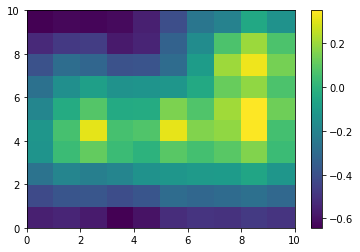

  7%|▋         | 35/500 [00:20<04:45,  1.63it/s]

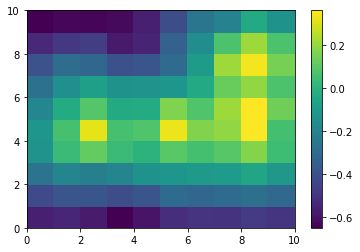

  7%|▋         | 36/500 [00:20<04:41,  1.65it/s]

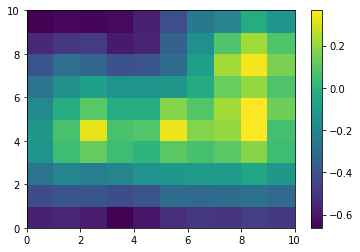

  7%|▋         | 37/500 [00:21<04:38,  1.66it/s]

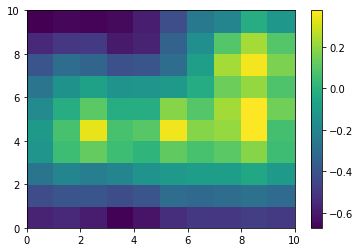

  8%|▊         | 38/500 [00:21<04:40,  1.65it/s]

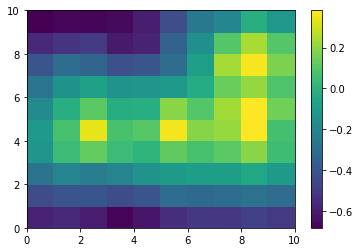

  8%|▊         | 39/500 [00:22<04:38,  1.65it/s]

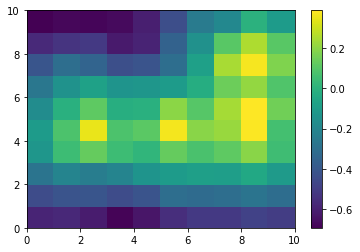

  8%|▊         | 40/500 [00:23<04:47,  1.60it/s]

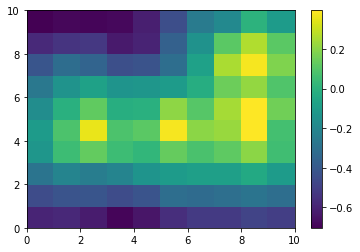

  8%|▊         | 41/500 [00:23<04:43,  1.62it/s]

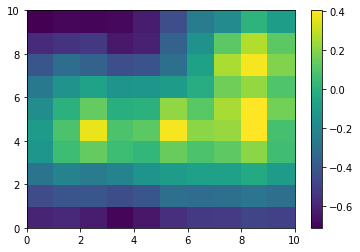

  8%|▊         | 42/500 [00:24<04:41,  1.63it/s]

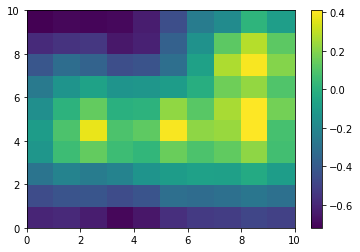

  9%|▊         | 43/500 [00:25<04:40,  1.63it/s]

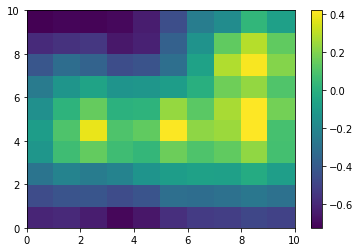

  9%|▉         | 44/500 [00:25<04:38,  1.64it/s]

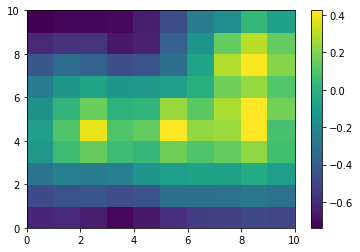

  9%|▉         | 45/500 [00:26<04:35,  1.65it/s]

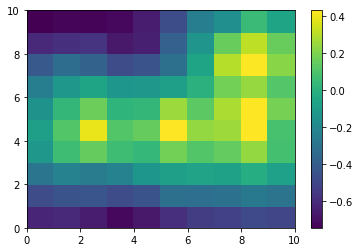

  9%|▉         | 46/500 [00:26<04:38,  1.63it/s]

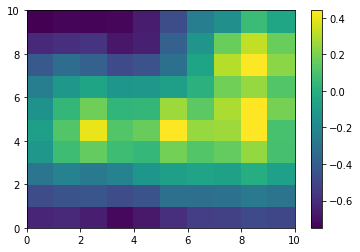

  9%|▉         | 47/500 [00:27<04:37,  1.63it/s]

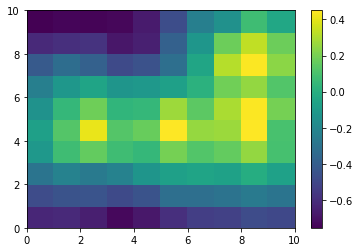

 10%|▉         | 48/500 [00:28<04:38,  1.62it/s]

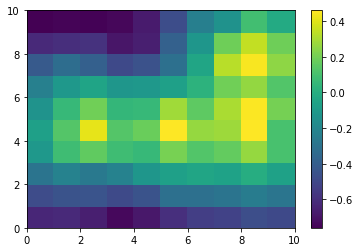

 10%|▉         | 49/500 [00:28<04:41,  1.60it/s]

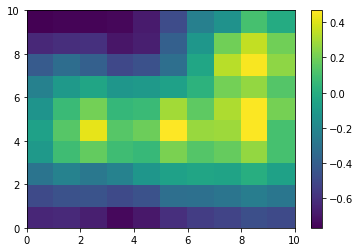

 10%|█         | 50/500 [00:29<04:41,  1.60it/s]

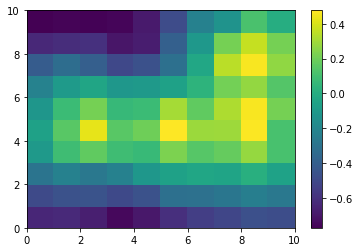

 10%|█         | 51/500 [00:30<04:53,  1.53it/s]

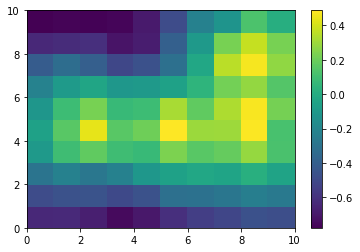

 10%|█         | 52/500 [00:30<04:48,  1.55it/s]

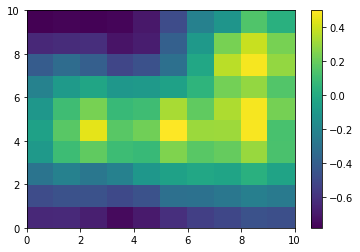

 11%|█         | 53/500 [00:31<04:44,  1.57it/s]

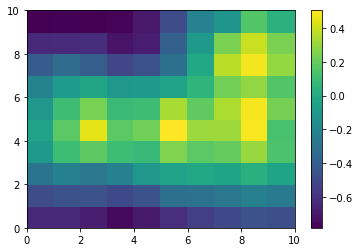

 11%|█         | 54/500 [00:32<04:44,  1.56it/s]

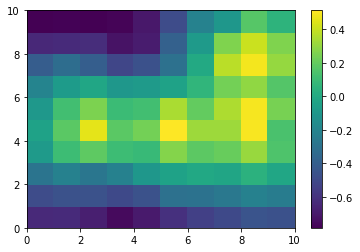

 11%|█         | 55/500 [00:32<04:41,  1.58it/s]

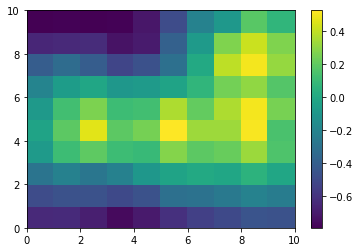

 11%|█         | 56/500 [00:33<04:41,  1.58it/s]

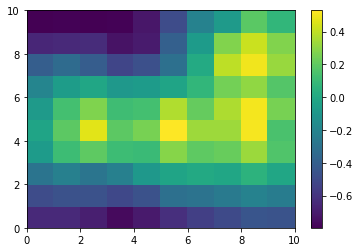

 11%|█▏        | 57/500 [00:33<04:43,  1.57it/s]

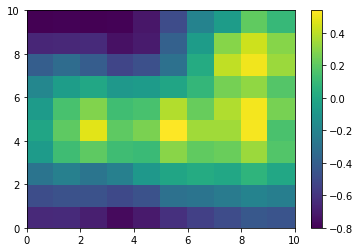

 12%|█▏        | 58/500 [00:34<04:41,  1.57it/s]

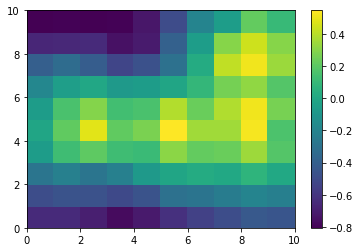

 12%|█▏        | 59/500 [00:35<04:41,  1.57it/s]

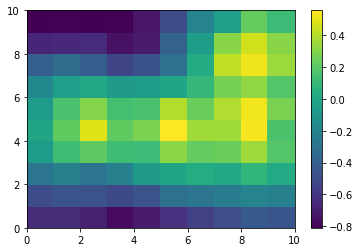

 12%|█▏        | 60/500 [00:35<04:42,  1.56it/s]

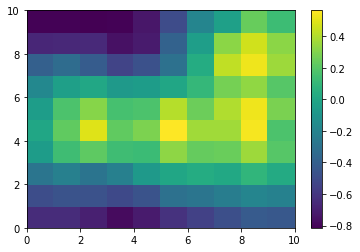

 12%|█▏        | 61/500 [00:36<04:40,  1.56it/s]

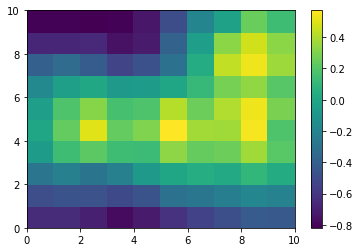

 12%|█▏        | 62/500 [00:37<04:52,  1.50it/s]

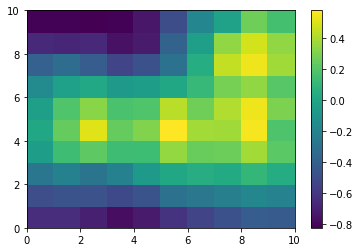

 13%|█▎        | 63/500 [00:37<04:50,  1.50it/s]

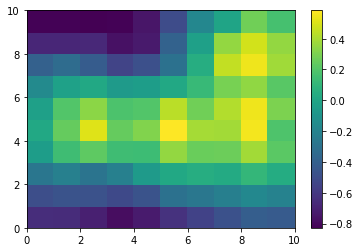

 13%|█▎        | 64/500 [00:38<04:47,  1.52it/s]

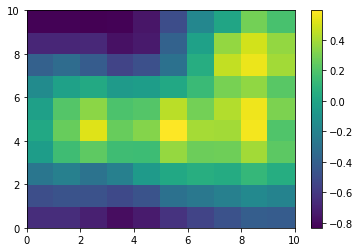

 13%|█▎        | 65/500 [00:39<04:45,  1.53it/s]

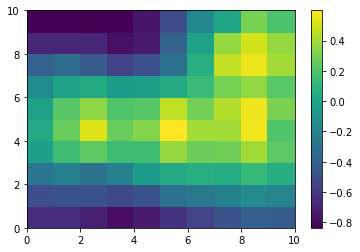

 13%|█▎        | 66/500 [00:39<04:43,  1.53it/s]

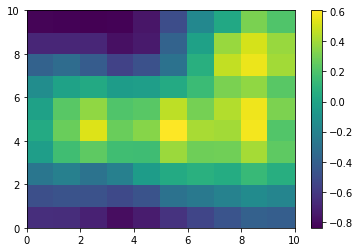

 13%|█▎        | 67/500 [00:40<04:44,  1.52it/s]

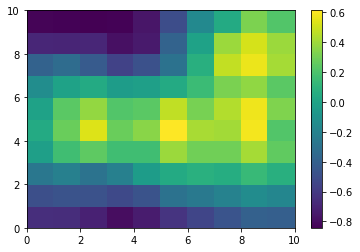

 14%|█▎        | 68/500 [00:41<04:40,  1.54it/s]

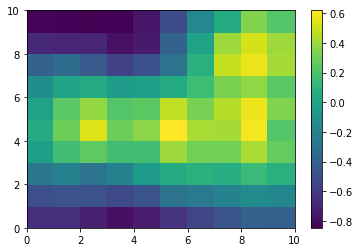

 14%|█▍        | 69/500 [00:41<04:37,  1.55it/s]

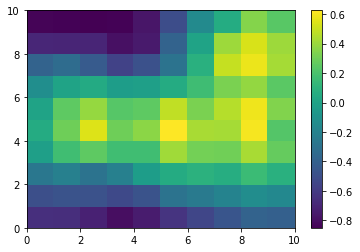

 14%|█▍        | 70/500 [00:42<04:39,  1.54it/s]

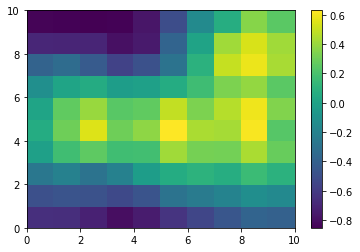

 14%|█▍        | 71/500 [00:43<04:38,  1.54it/s]

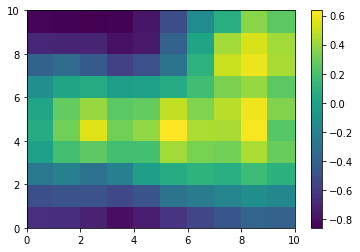

 14%|█▍        | 72/500 [00:43<04:37,  1.54it/s]

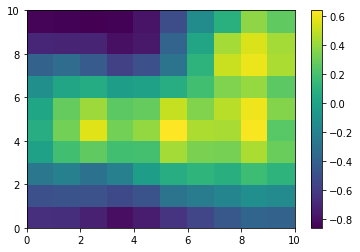

 15%|█▍        | 73/500 [00:44<04:45,  1.50it/s]

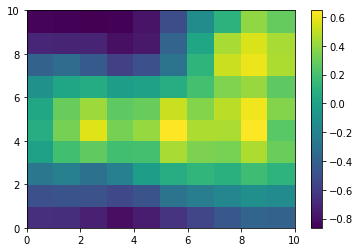

 15%|█▍        | 74/500 [00:45<04:41,  1.51it/s]

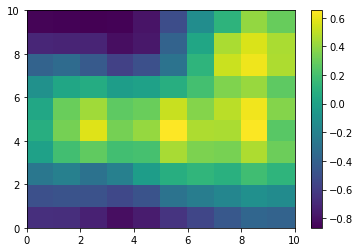

 15%|█▌        | 75/500 [00:45<04:36,  1.54it/s]

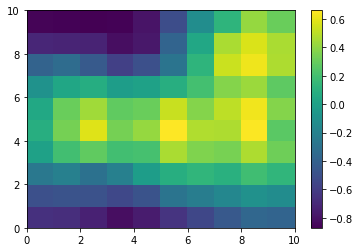

 15%|█▌        | 76/500 [00:46<04:37,  1.53it/s]

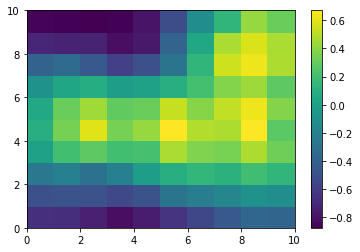

 15%|█▌        | 77/500 [00:46<04:34,  1.54it/s]

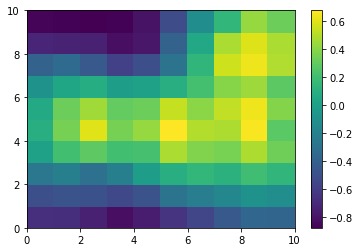

 16%|█▌        | 78/500 [00:47<04:35,  1.53it/s]

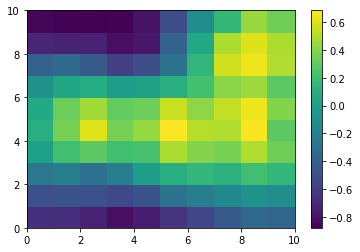

 16%|█▌        | 79/500 [00:48<04:33,  1.54it/s]

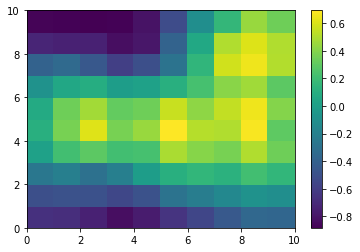

 16%|█▌        | 80/500 [00:48<04:35,  1.52it/s]

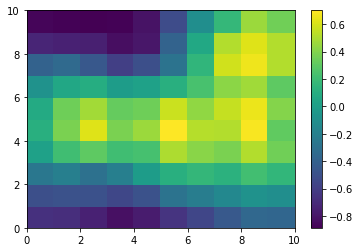

 16%|█▌        | 81/500 [00:49<04:33,  1.53it/s]

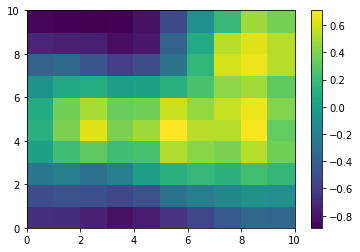

 16%|█▋        | 82/500 [00:50<04:36,  1.51it/s]

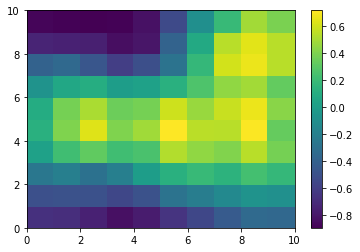

 17%|█▋        | 83/500 [00:50<04:33,  1.52it/s]

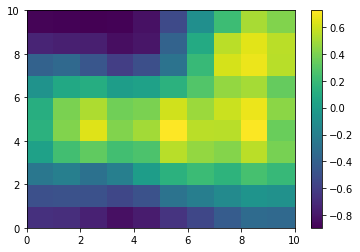

 17%|█▋        | 84/500 [00:51<04:47,  1.45it/s]

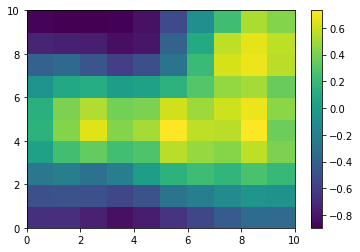

 17%|█▋        | 85/500 [00:52<04:45,  1.45it/s]

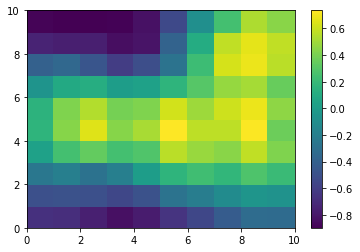

 17%|█▋        | 86/500 [00:53<04:39,  1.48it/s]

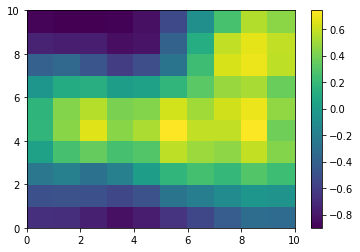

 17%|█▋        | 87/500 [00:53<04:37,  1.49it/s]

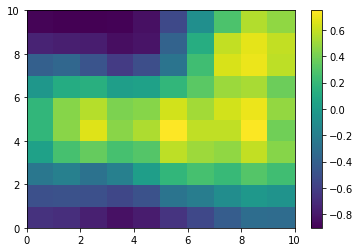

 18%|█▊        | 88/500 [00:54<04:34,  1.50it/s]

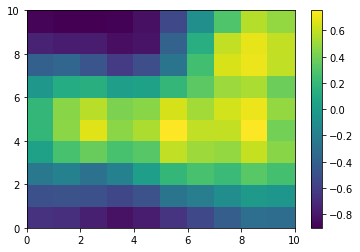

 18%|█▊        | 89/500 [00:55<04:32,  1.51it/s]

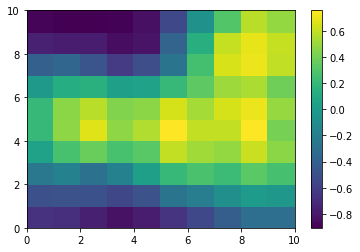

 18%|█▊        | 90/500 [00:55<04:30,  1.51it/s]

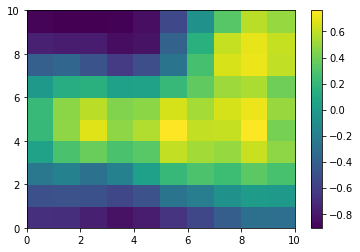

 18%|█▊        | 91/500 [00:56<04:30,  1.51it/s]

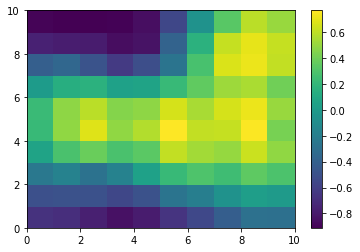

 18%|█▊        | 92/500 [00:56<04:31,  1.50it/s]

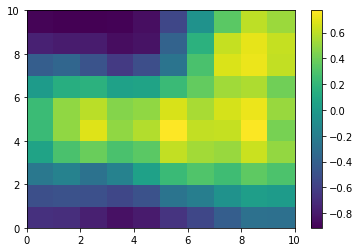

 19%|█▊        | 93/500 [00:57<04:31,  1.50it/s]

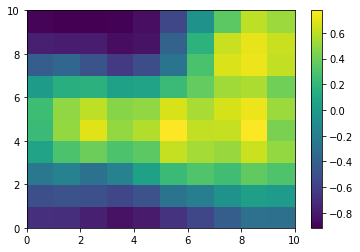

 19%|█▉        | 94/500 [00:58<04:29,  1.51it/s]

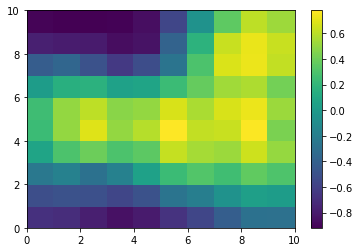

 19%|█▉        | 95/500 [00:59<04:38,  1.45it/s]

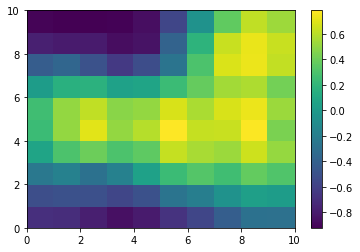

 19%|█▉        | 96/500 [00:59<04:35,  1.47it/s]

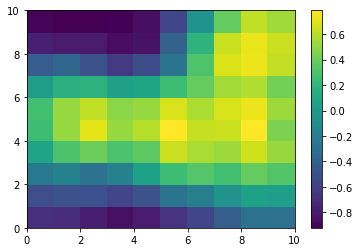

 19%|█▉        | 97/500 [01:00<04:32,  1.48it/s]

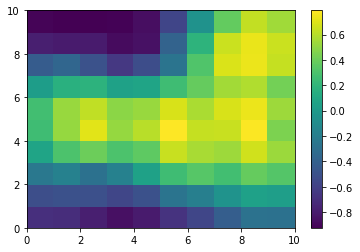

 20%|█▉        | 98/500 [01:01<04:30,  1.48it/s]

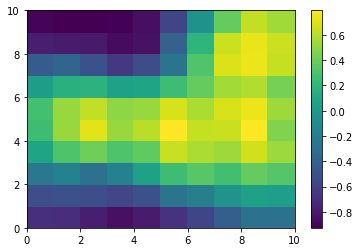

 20%|█▉        | 99/500 [01:01<04:32,  1.47it/s]

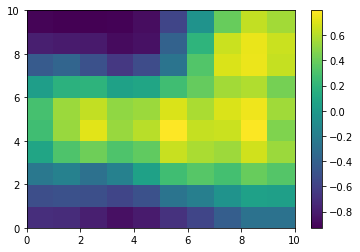

 20%|██        | 100/500 [01:02<04:28,  1.49it/s]

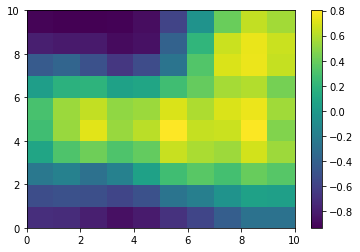

 20%|██        | 101/500 [01:03<04:28,  1.48it/s]

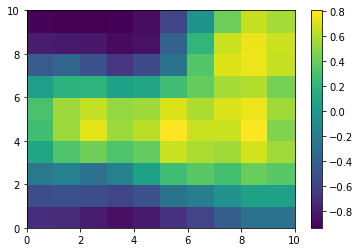

 20%|██        | 102/500 [01:03<04:27,  1.49it/s]

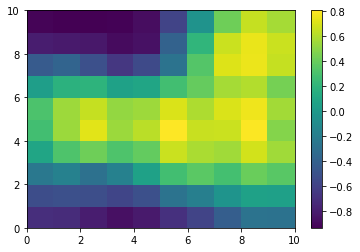

 21%|██        | 103/500 [01:04<04:26,  1.49it/s]

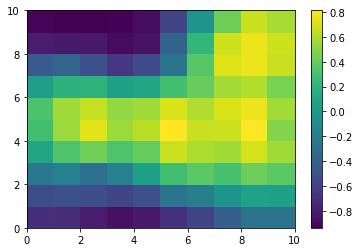

 21%|██        | 104/500 [01:05<04:24,  1.50it/s]

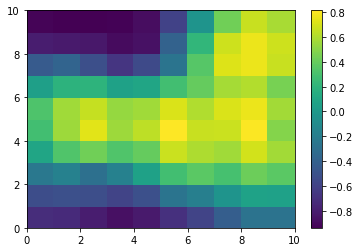

 21%|██        | 105/500 [01:05<04:24,  1.49it/s]

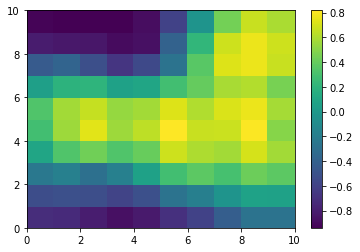

 21%|██        | 106/500 [01:06<04:31,  1.45it/s]

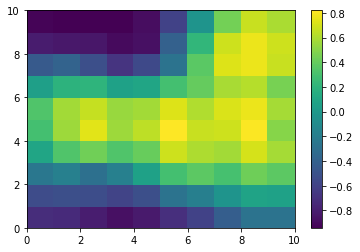

 21%|██▏       | 107/500 [01:07<04:27,  1.47it/s]

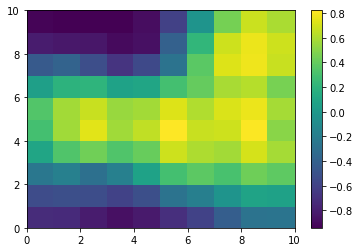

 22%|██▏       | 108/500 [01:07<04:27,  1.47it/s]

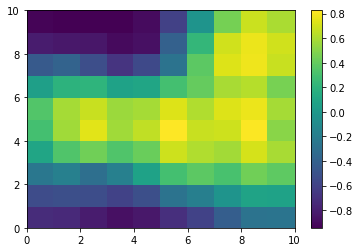

 22%|██▏       | 109/500 [01:08<04:26,  1.47it/s]

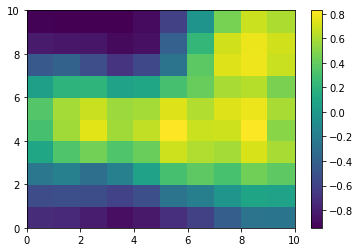

 22%|██▏       | 110/500 [01:09<04:25,  1.47it/s]

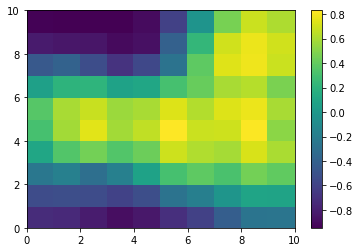

 22%|██▏       | 111/500 [01:09<04:23,  1.48it/s]

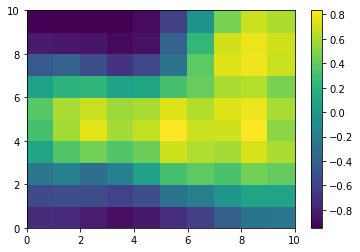

 22%|██▏       | 112/500 [01:10<04:20,  1.49it/s]

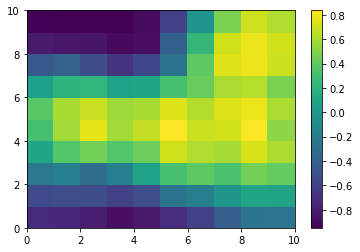

 23%|██▎       | 113/500 [01:11<04:18,  1.50it/s]

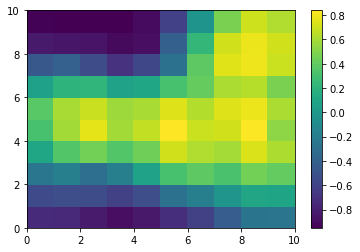

 23%|██▎       | 114/500 [01:11<04:18,  1.49it/s]

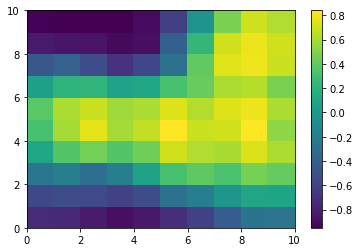

 23%|██▎       | 115/500 [01:12<04:17,  1.50it/s]

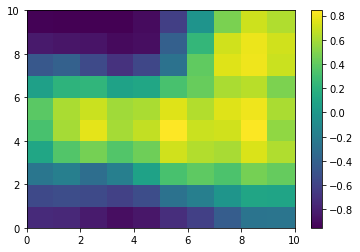

 23%|██▎       | 116/500 [01:13<04:16,  1.50it/s]

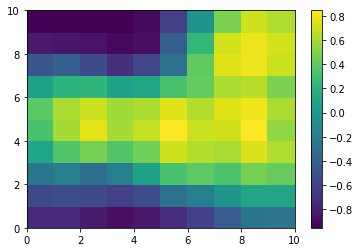

 23%|██▎       | 117/500 [01:13<04:23,  1.45it/s]

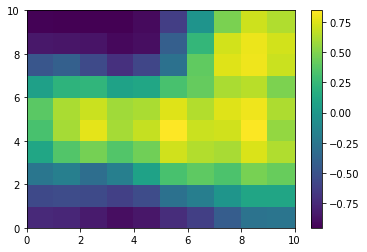

 24%|██▎       | 118/500 [01:14<04:17,  1.48it/s]

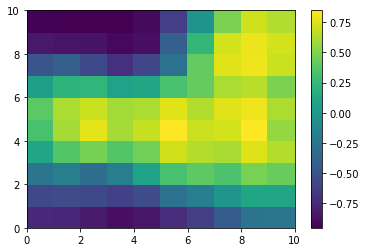

 24%|██▍       | 119/500 [01:15<04:14,  1.50it/s]

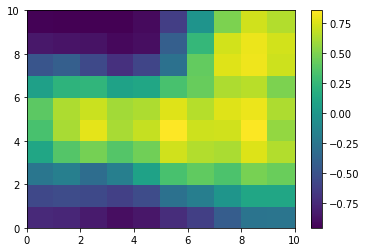

 24%|██▍       | 120/500 [01:15<04:12,  1.51it/s]

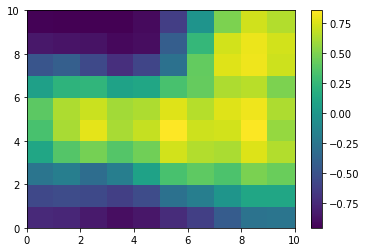

 24%|██▍       | 121/500 [01:16<04:09,  1.52it/s]

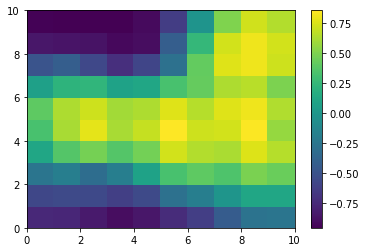

 24%|██▍       | 122/500 [01:17<04:08,  1.52it/s]

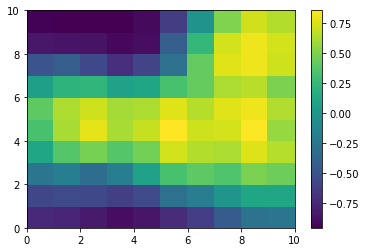

 25%|██▍       | 123/500 [01:17<04:09,  1.51it/s]

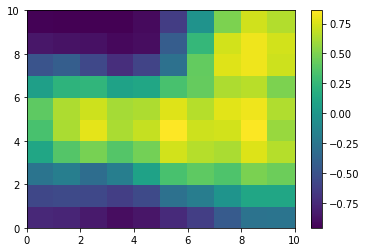

 25%|██▍       | 124/500 [01:18<04:09,  1.51it/s]

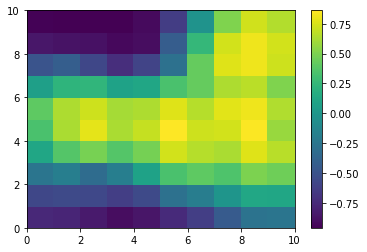

 25%|██▌       | 125/500 [01:19<04:08,  1.51it/s]

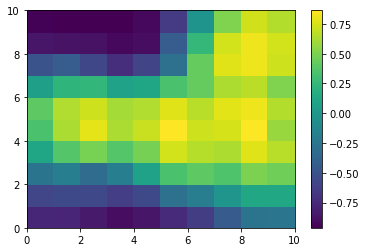

 25%|██▌       | 126/500 [01:19<04:07,  1.51it/s]

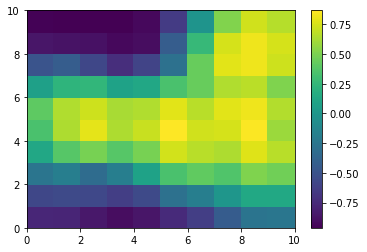

 25%|██▌       | 127/500 [01:20<04:05,  1.52it/s]

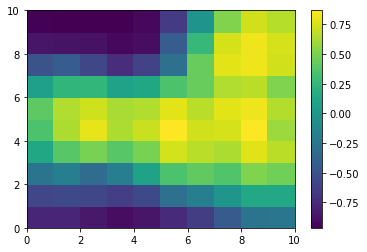

 26%|██▌       | 128/500 [01:21<04:14,  1.46it/s]

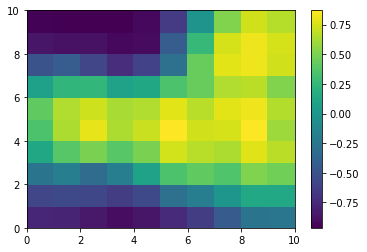

 26%|██▌       | 129/500 [01:21<04:10,  1.48it/s]

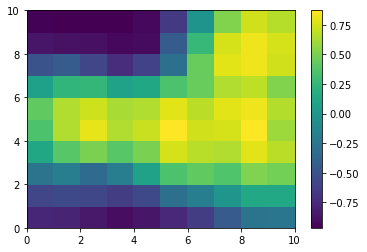

 26%|██▌       | 130/500 [01:22<04:07,  1.50it/s]

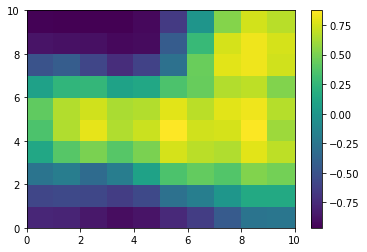

 26%|██▌       | 131/500 [01:23<04:06,  1.50it/s]

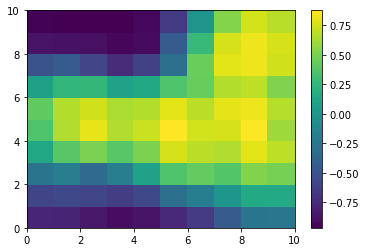

 26%|██▋       | 132/500 [01:23<04:07,  1.49it/s]

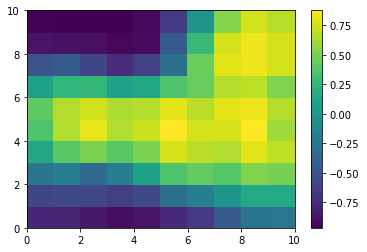

 27%|██▋       | 133/500 [01:24<04:04,  1.50it/s]

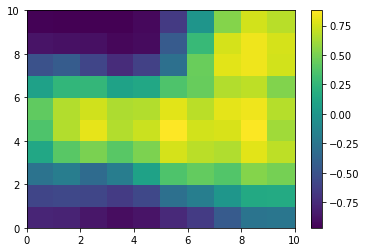

 27%|██▋       | 134/500 [01:25<04:03,  1.50it/s]

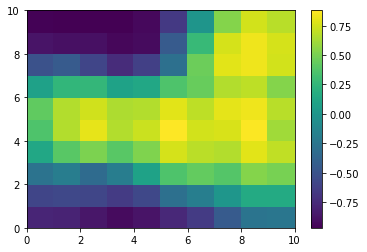

 27%|██▋       | 135/500 [01:25<04:03,  1.50it/s]

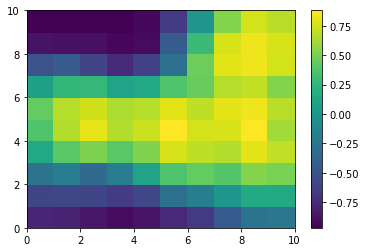

 27%|██▋       | 136/500 [01:26<04:01,  1.51it/s]

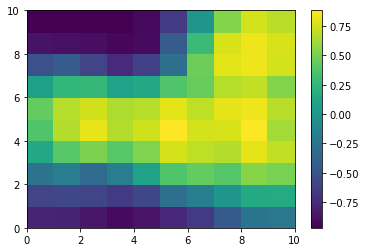

 27%|██▋       | 137/500 [01:27<04:01,  1.50it/s]

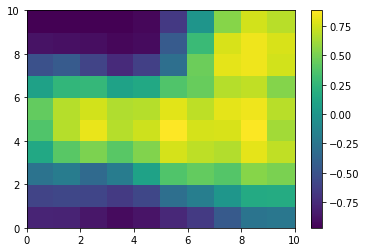

 28%|██▊       | 138/500 [01:27<04:02,  1.49it/s]

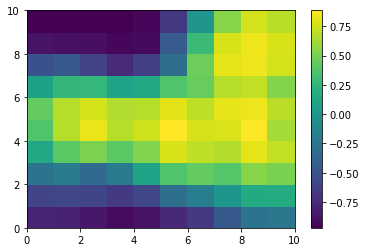

 28%|██▊       | 139/500 [01:28<04:08,  1.45it/s]

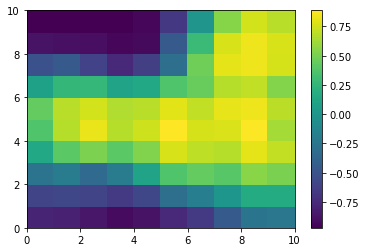

 28%|██▊       | 140/500 [01:29<04:04,  1.47it/s]

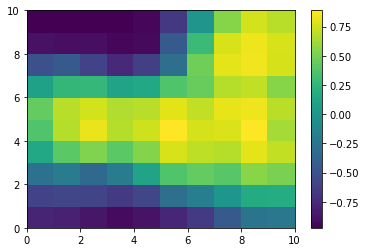

 28%|██▊       | 141/500 [01:29<04:00,  1.49it/s]

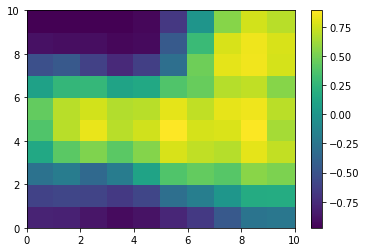

 28%|██▊       | 142/500 [01:30<03:56,  1.51it/s]

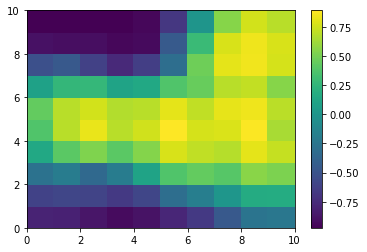

 29%|██▊       | 143/500 [01:31<03:55,  1.52it/s]

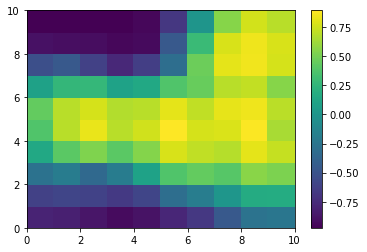

 29%|██▉       | 144/500 [01:31<03:53,  1.52it/s]

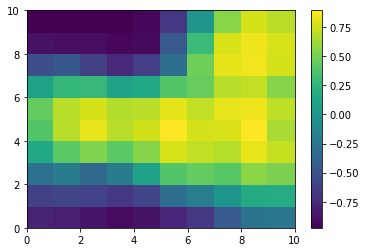

 29%|██▉       | 145/500 [01:32<03:52,  1.52it/s]

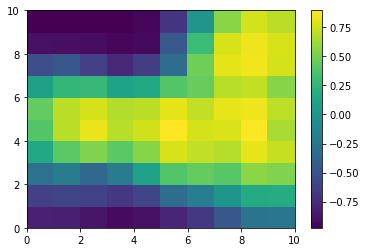

 29%|██▉       | 146/500 [01:33<03:52,  1.52it/s]

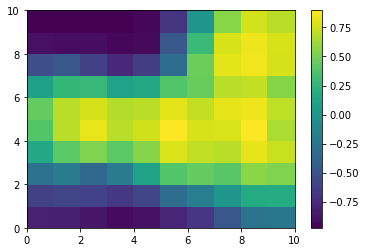

 29%|██▉       | 147/500 [01:33<03:51,  1.52it/s]

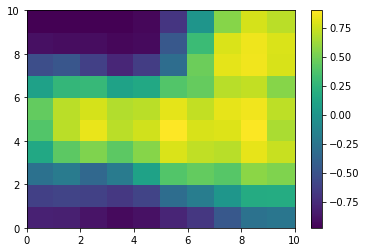

 30%|██▉       | 148/500 [01:34<03:50,  1.53it/s]

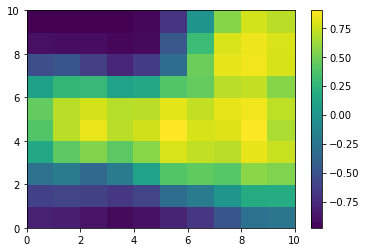

 30%|██▉       | 149/500 [01:35<03:51,  1.52it/s]

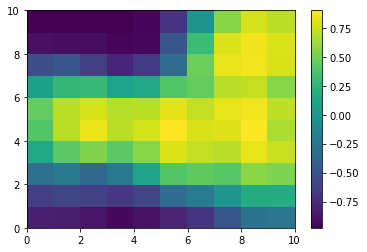

 30%|███       | 150/500 [01:35<04:03,  1.44it/s]

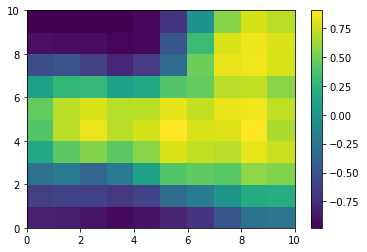

 30%|███       | 151/500 [01:36<03:59,  1.46it/s]

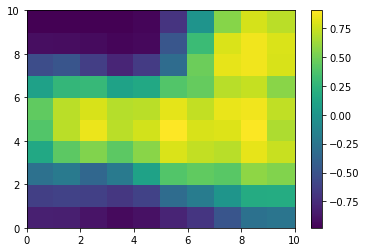

 30%|███       | 152/500 [01:37<03:56,  1.47it/s]

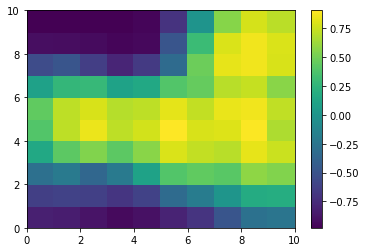

 31%|███       | 153/500 [01:37<03:54,  1.48it/s]

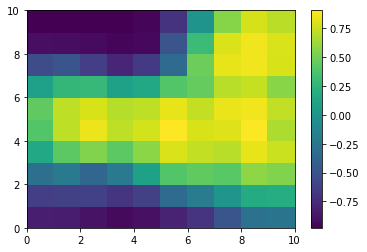

 31%|███       | 154/500 [01:38<03:51,  1.49it/s]

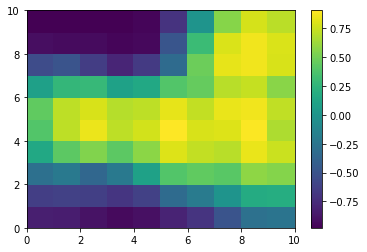

 31%|███       | 155/500 [01:39<03:52,  1.48it/s]

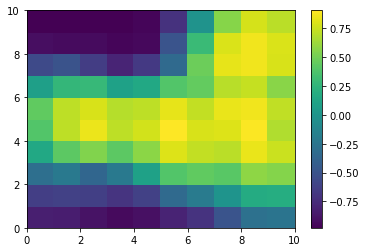

 31%|███       | 156/500 [01:39<03:49,  1.50it/s]

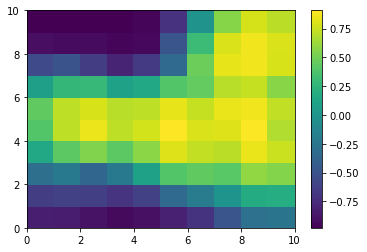

 31%|███▏      | 157/500 [01:40<03:48,  1.50it/s]

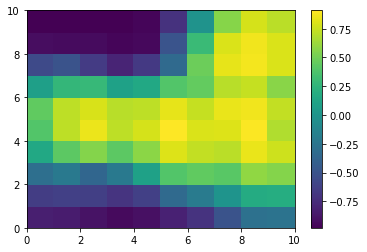

 32%|███▏      | 158/500 [01:41<03:49,  1.49it/s]

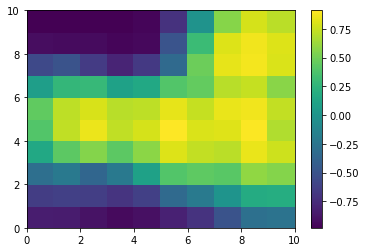

 32%|███▏      | 159/500 [01:41<03:48,  1.49it/s]

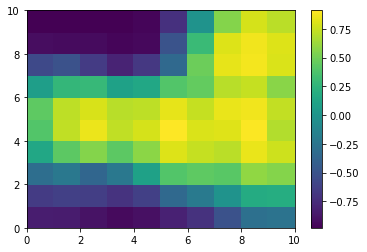

 32%|███▏      | 160/500 [01:42<03:49,  1.48it/s]

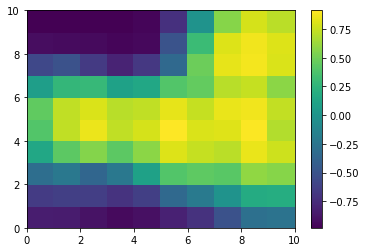

 32%|███▏      | 161/500 [01:43<03:57,  1.42it/s]

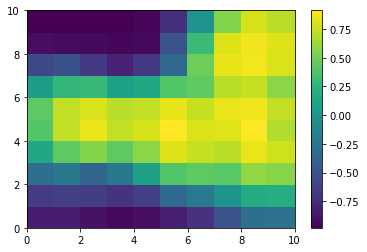

 32%|███▏      | 162/500 [01:44<03:52,  1.45it/s]

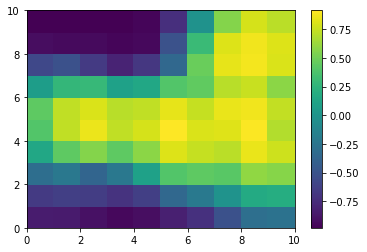

 33%|███▎      | 163/500 [01:44<03:51,  1.46it/s]

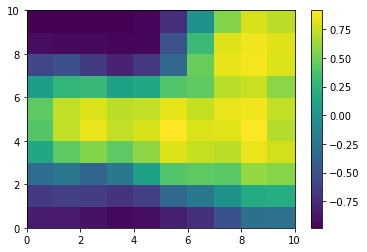

 33%|███▎      | 164/500 [01:45<03:48,  1.47it/s]

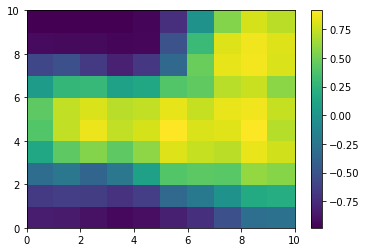

 33%|███▎      | 165/500 [01:46<03:47,  1.47it/s]

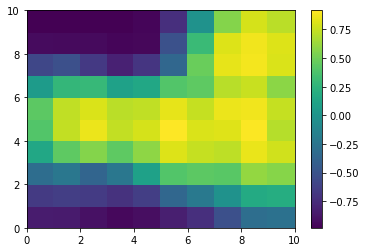

 33%|███▎      | 166/500 [01:46<03:45,  1.48it/s]

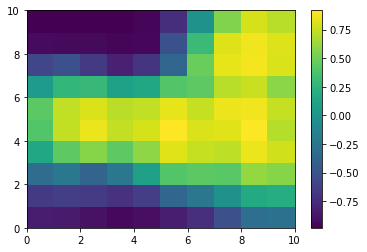

 33%|███▎      | 167/500 [01:47<03:45,  1.48it/s]

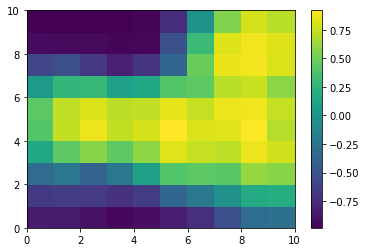

 34%|███▎      | 168/500 [01:48<03:44,  1.48it/s]

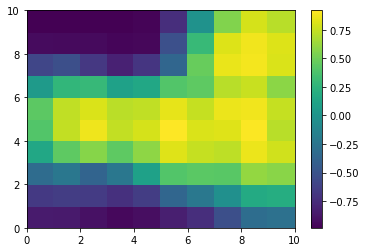

 34%|███▍      | 169/500 [01:48<03:41,  1.50it/s]

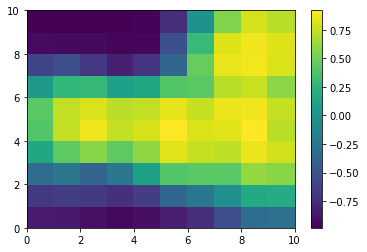

 34%|███▍      | 170/500 [01:49<03:40,  1.50it/s]

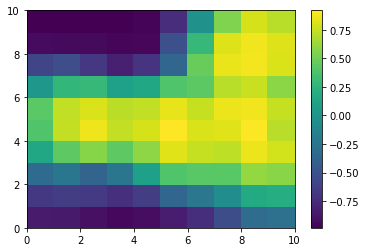

 34%|███▍      | 171/500 [01:50<03:39,  1.50it/s]

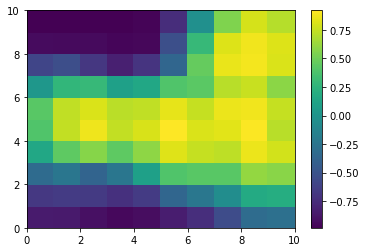

 34%|███▍      | 172/500 [01:50<03:50,  1.42it/s]

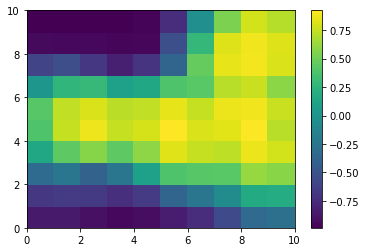

 35%|███▍      | 173/500 [01:51<03:46,  1.44it/s]

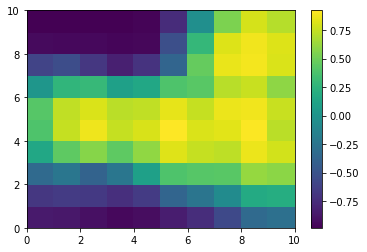

 35%|███▍      | 174/500 [01:52<03:45,  1.44it/s]

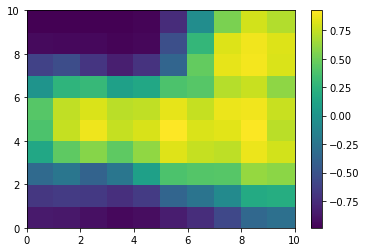

 35%|███▌      | 175/500 [01:52<03:41,  1.47it/s]

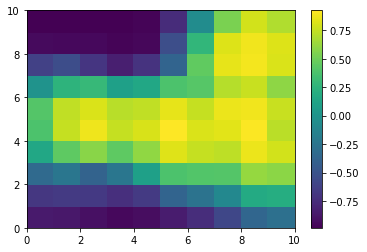

 35%|███▌      | 176/500 [01:53<03:41,  1.47it/s]

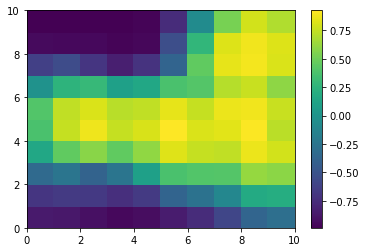

 35%|███▌      | 177/500 [01:54<03:38,  1.48it/s]

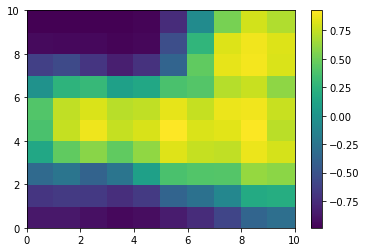

 36%|███▌      | 178/500 [01:54<03:34,  1.50it/s]

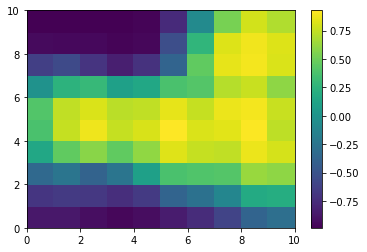

 36%|███▌      | 179/500 [01:55<03:33,  1.51it/s]

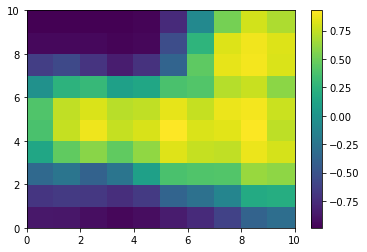

 36%|███▌      | 180/500 [01:56<03:32,  1.51it/s]

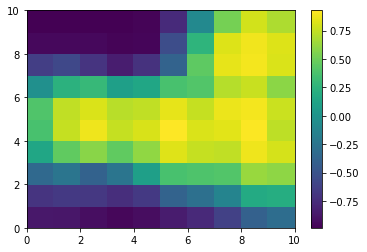

 36%|███▌      | 181/500 [01:56<03:30,  1.51it/s]

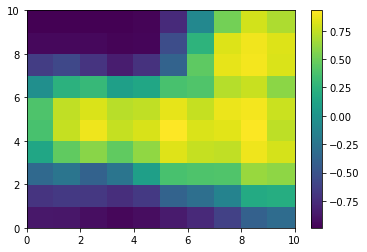

 36%|███▋      | 182/500 [01:57<03:30,  1.51it/s]

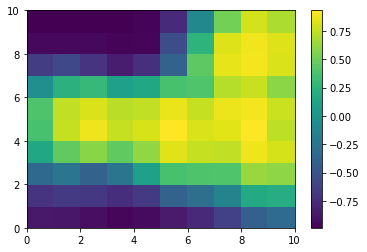

 37%|███▋      | 183/500 [01:58<03:38,  1.45it/s]

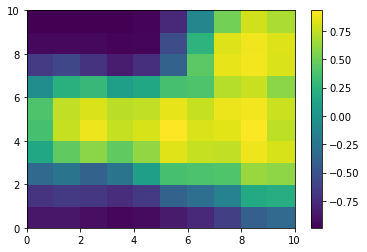

 37%|███▋      | 184/500 [01:58<03:35,  1.46it/s]

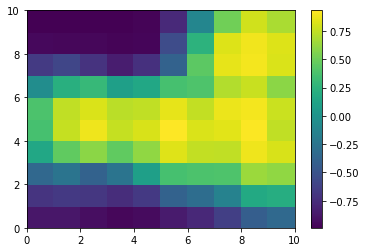

 37%|███▋      | 185/500 [01:59<03:35,  1.46it/s]

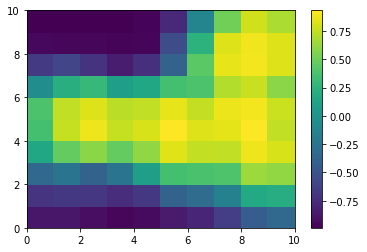

 37%|███▋      | 186/500 [02:00<03:33,  1.47it/s]

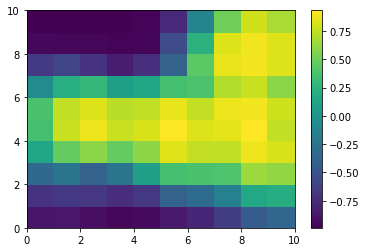

 37%|███▋      | 187/500 [02:00<03:30,  1.48it/s]

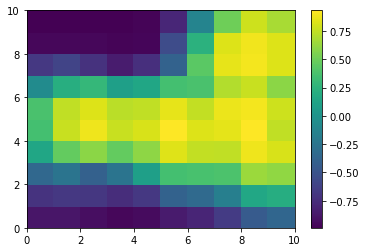

 38%|███▊      | 188/500 [02:01<03:27,  1.50it/s]

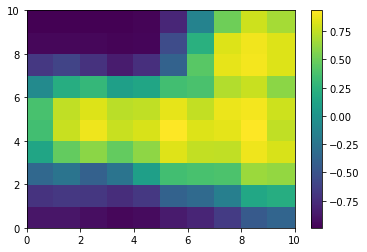

 38%|███▊      | 189/500 [02:02<03:25,  1.51it/s]

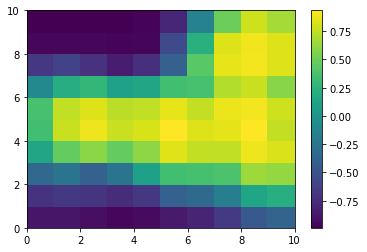

 38%|███▊      | 190/500 [02:02<03:26,  1.50it/s]

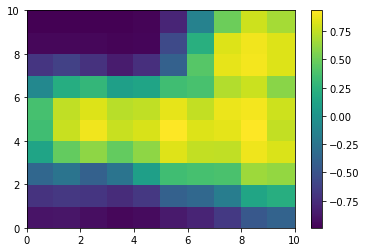

 38%|███▊      | 191/500 [02:03<03:25,  1.51it/s]

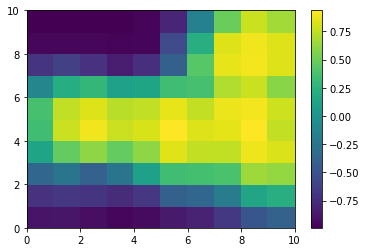

 38%|███▊      | 192/500 [02:04<03:24,  1.50it/s]

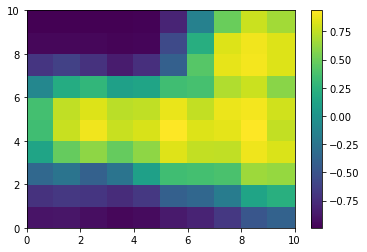

 39%|███▊      | 193/500 [02:04<03:22,  1.51it/s]

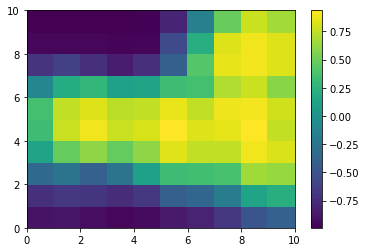

 39%|███▉      | 194/500 [02:05<03:28,  1.46it/s]

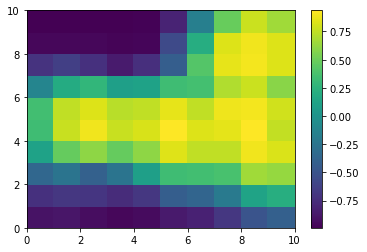

 39%|███▉      | 195/500 [02:06<03:26,  1.48it/s]

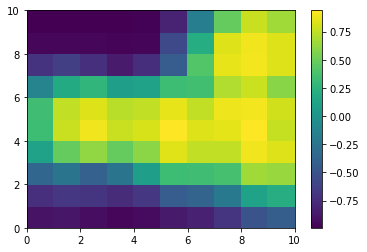

 39%|███▉      | 196/500 [02:06<03:25,  1.48it/s]

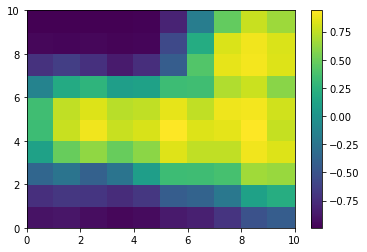

 39%|███▉      | 197/500 [02:07<03:21,  1.51it/s]

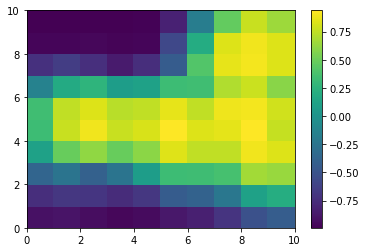

 40%|███▉      | 198/500 [02:08<03:19,  1.52it/s]

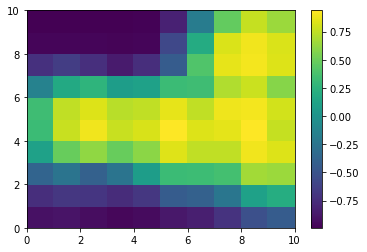

 40%|███▉      | 199/500 [02:08<03:17,  1.52it/s]

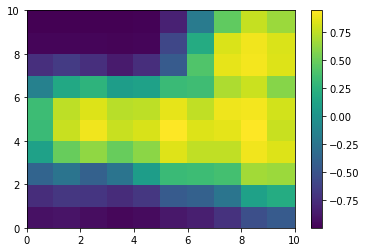

 40%|████      | 200/500 [02:09<03:18,  1.51it/s]

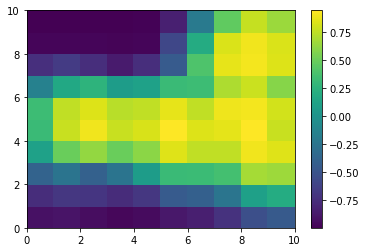

 40%|████      | 201/500 [02:10<03:17,  1.52it/s]

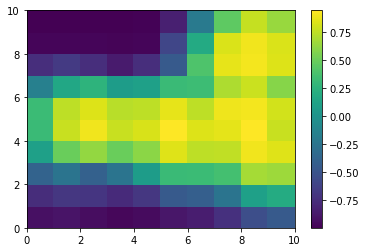

 40%|████      | 202/500 [02:10<03:15,  1.52it/s]

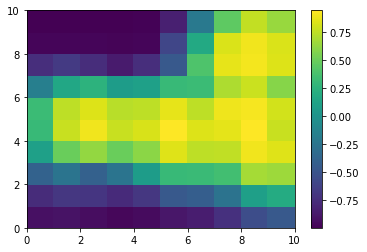

 41%|████      | 203/500 [02:11<03:14,  1.52it/s]

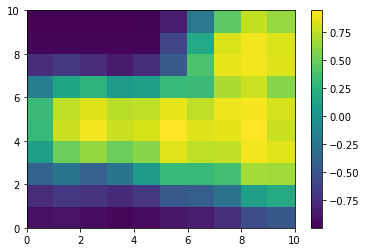

 41%|████      | 204/500 [02:12<03:14,  1.52it/s]

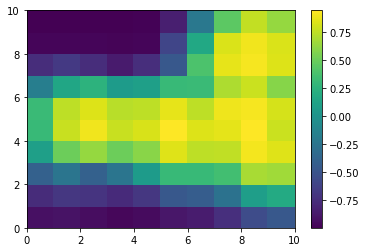

 41%|████      | 205/500 [02:12<03:22,  1.46it/s]

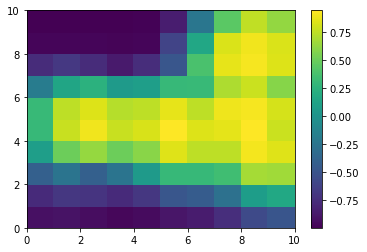

 41%|████      | 206/500 [02:13<03:18,  1.48it/s]

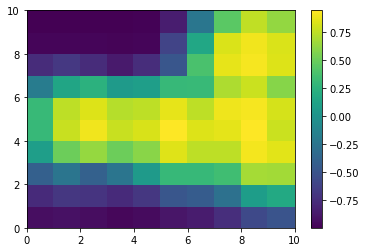

 41%|████▏     | 207/500 [02:14<03:15,  1.50it/s]

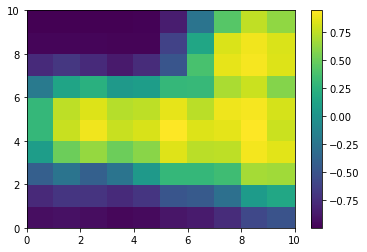

 42%|████▏     | 208/500 [02:14<03:13,  1.51it/s]

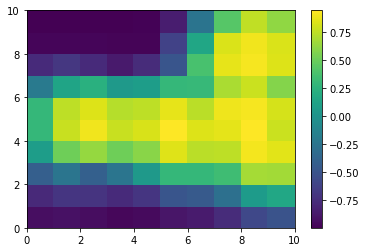

 42%|████▏     | 209/500 [02:15<03:11,  1.52it/s]

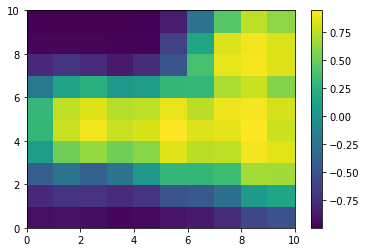

 42%|████▏     | 210/500 [02:16<03:11,  1.51it/s]

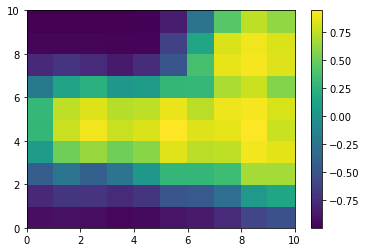

 42%|████▏     | 211/500 [02:16<03:11,  1.51it/s]

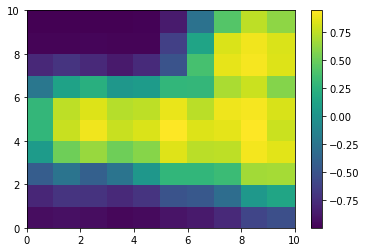

 42%|████▏     | 212/500 [02:17<03:11,  1.51it/s]

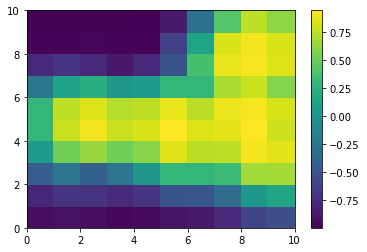

 43%|████▎     | 213/500 [02:18<03:10,  1.50it/s]

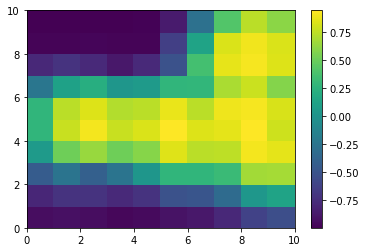

 43%|████▎     | 214/500 [02:18<03:10,  1.50it/s]

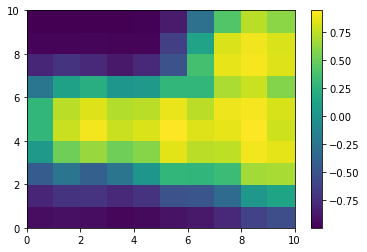

 43%|████▎     | 215/500 [02:19<03:09,  1.51it/s]

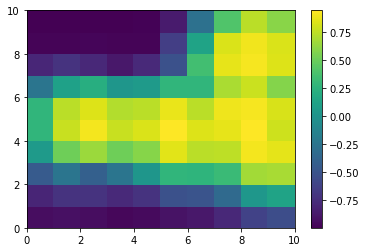

 43%|████▎     | 216/500 [02:20<03:18,  1.43it/s]

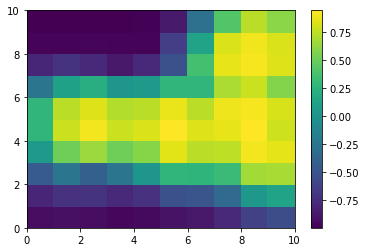

 43%|████▎     | 217/500 [02:20<03:15,  1.45it/s]

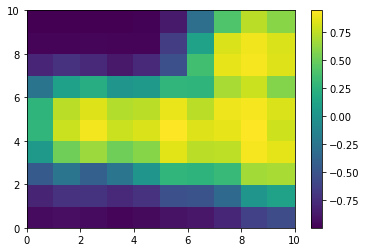

 44%|████▎     | 218/500 [02:21<03:11,  1.47it/s]

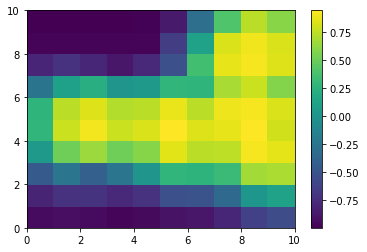

 44%|████▍     | 219/500 [02:22<03:10,  1.48it/s]

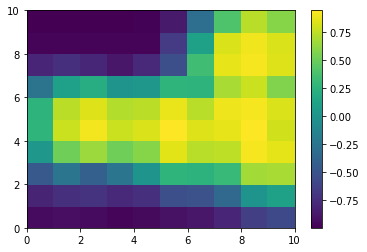

 44%|████▍     | 220/500 [02:22<03:07,  1.49it/s]

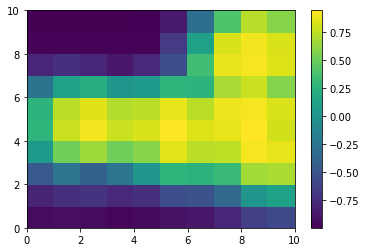

 44%|████▍     | 221/500 [02:23<03:03,  1.52it/s]

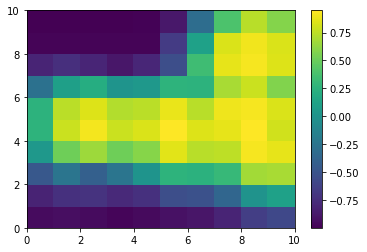

 44%|████▍     | 222/500 [02:24<03:03,  1.52it/s]

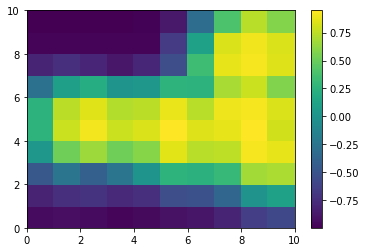

 45%|████▍     | 223/500 [02:24<03:02,  1.52it/s]

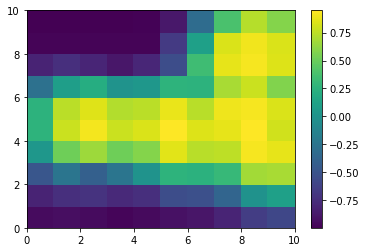

 45%|████▍     | 224/500 [02:25<03:00,  1.53it/s]

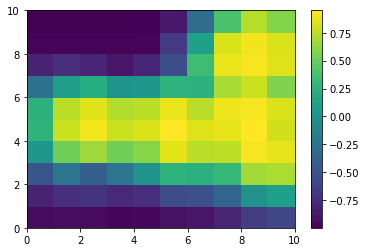

 45%|████▌     | 225/500 [02:26<03:00,  1.52it/s]

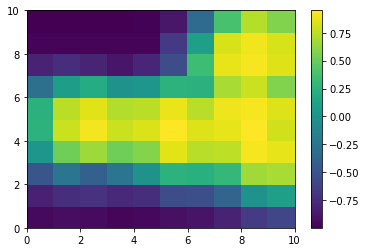

 45%|████▌     | 226/500 [02:26<03:00,  1.52it/s]

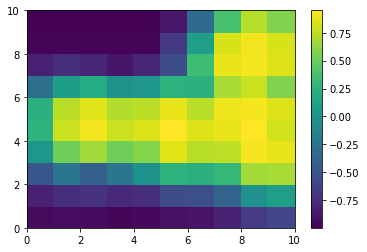

 45%|████▌     | 227/500 [02:27<03:09,  1.44it/s]

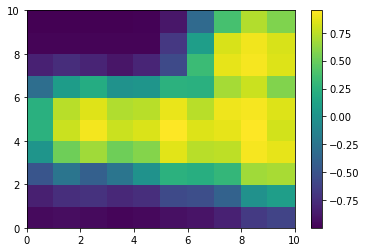

 46%|████▌     | 228/500 [02:28<03:04,  1.47it/s]

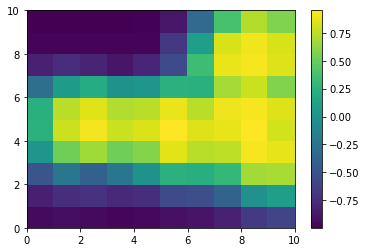

 46%|████▌     | 229/500 [02:28<03:02,  1.49it/s]

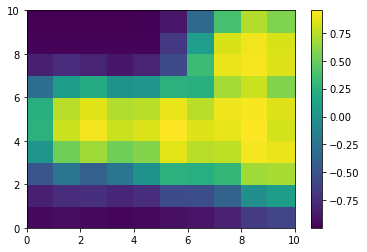

 46%|████▌     | 230/500 [02:29<02:59,  1.50it/s]

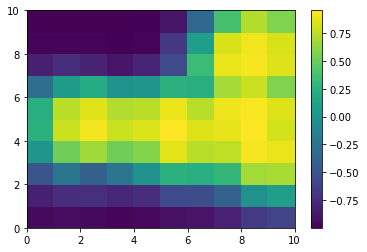

 46%|████▌     | 231/500 [02:30<02:58,  1.51it/s]

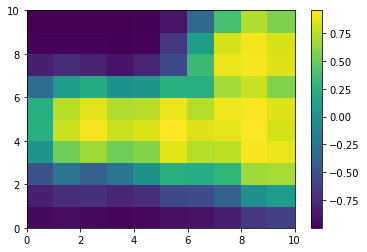

 46%|████▋     | 232/500 [02:30<02:58,  1.50it/s]

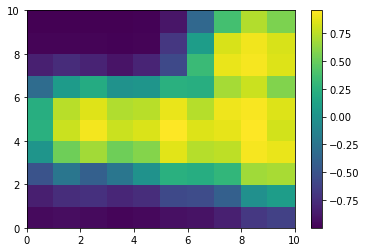

 47%|████▋     | 233/500 [02:31<02:56,  1.51it/s]

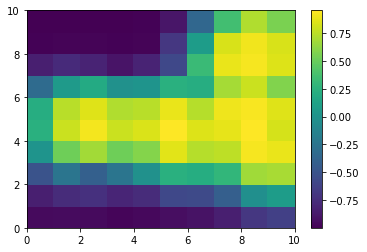

 47%|████▋     | 234/500 [02:32<02:55,  1.52it/s]

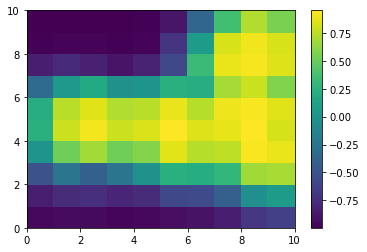

 47%|████▋     | 235/500 [02:32<02:54,  1.52it/s]

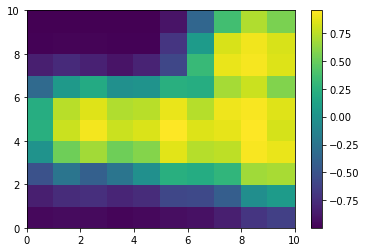

 47%|████▋     | 236/500 [02:33<02:52,  1.53it/s]

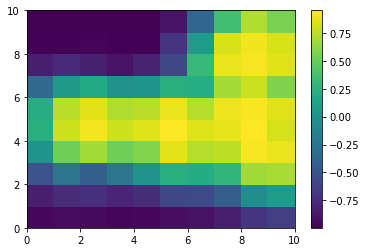

 47%|████▋     | 237/500 [02:34<02:53,  1.51it/s]

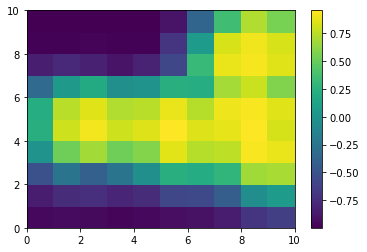

 48%|████▊     | 238/500 [02:34<02:57,  1.47it/s]

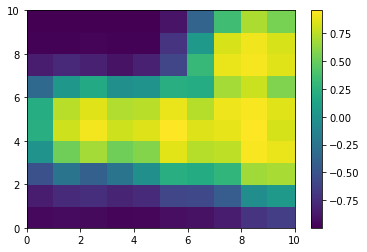

 48%|████▊     | 239/500 [02:35<02:56,  1.48it/s]

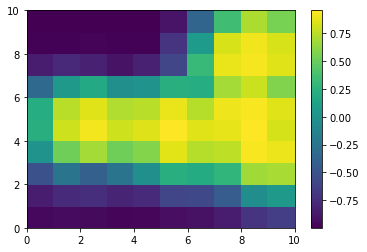

 48%|████▊     | 240/500 [02:36<02:55,  1.48it/s]

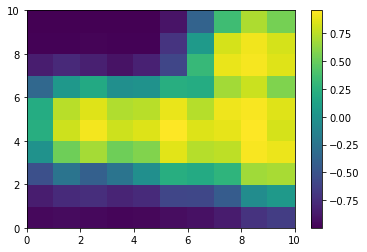

 48%|████▊     | 241/500 [02:36<02:53,  1.49it/s]

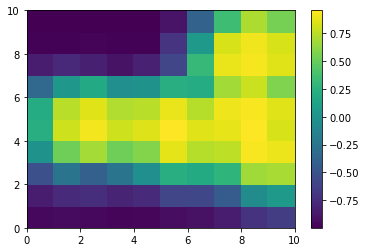

 48%|████▊     | 242/500 [02:37<02:50,  1.51it/s]

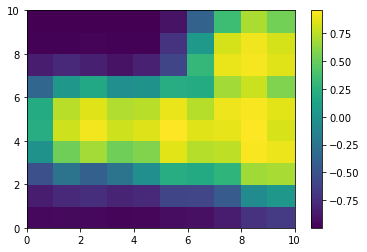

 49%|████▊     | 243/500 [02:38<02:49,  1.52it/s]

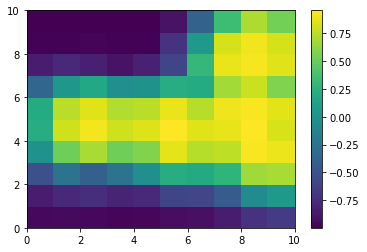

 49%|████▉     | 244/500 [02:38<02:47,  1.53it/s]

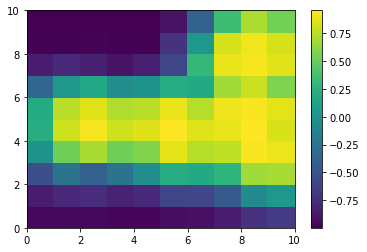

 49%|████▉     | 245/500 [02:39<02:46,  1.53it/s]

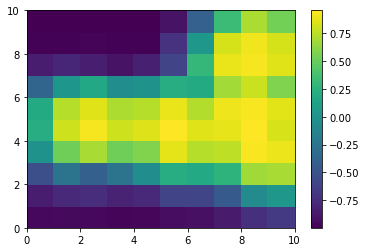

 49%|████▉     | 246/500 [02:40<02:46,  1.53it/s]

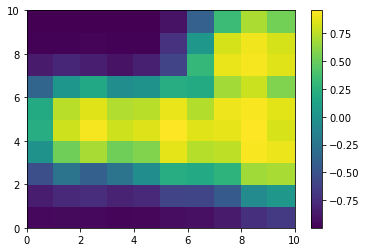

 49%|████▉     | 247/500 [02:40<02:43,  1.55it/s]

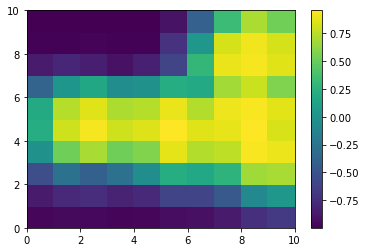

 50%|████▉     | 248/500 [02:41<02:42,  1.55it/s]

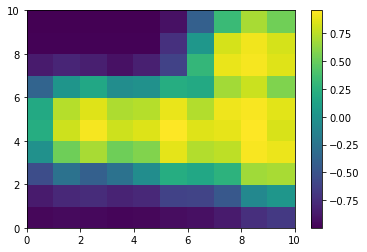

 50%|████▉     | 249/500 [02:42<02:48,  1.49it/s]

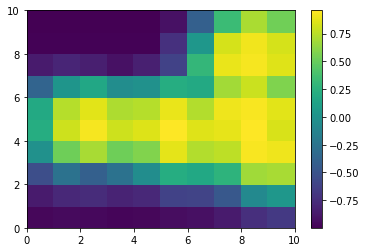

 50%|█████     | 250/500 [02:42<02:44,  1.52it/s]

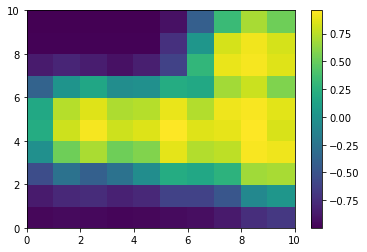

 50%|█████     | 251/500 [02:43<02:43,  1.53it/s]

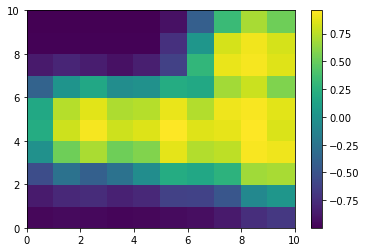

 50%|█████     | 252/500 [02:44<02:41,  1.53it/s]

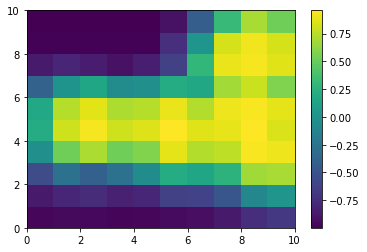

 51%|█████     | 253/500 [02:44<02:41,  1.53it/s]

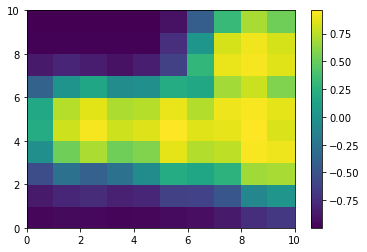

 51%|█████     | 254/500 [02:45<02:40,  1.53it/s]

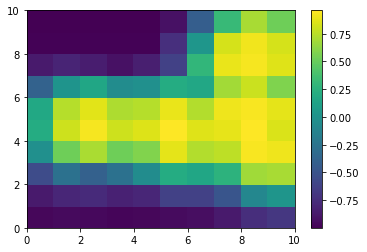

 51%|█████     | 255/500 [02:46<02:41,  1.52it/s]

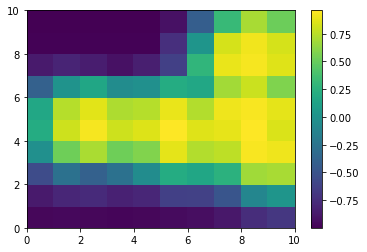

 51%|█████     | 256/500 [02:46<02:41,  1.51it/s]

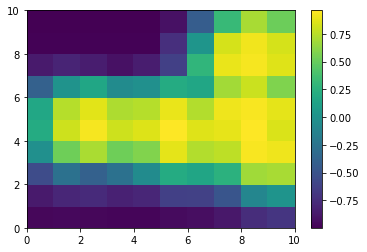

 51%|█████▏    | 257/500 [02:47<02:40,  1.51it/s]

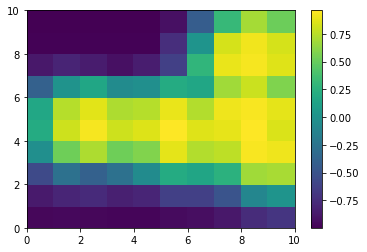

 52%|█████▏    | 258/500 [02:48<02:39,  1.52it/s]

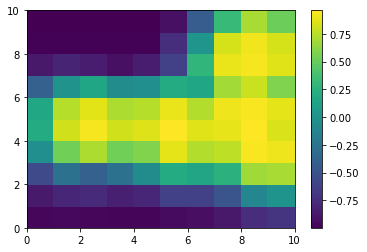

 52%|█████▏    | 259/500 [02:48<02:38,  1.52it/s]

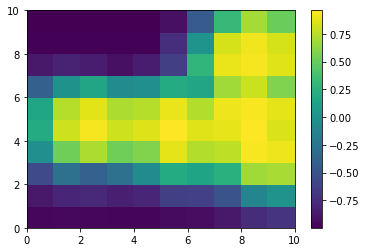

 52%|█████▏    | 260/500 [02:49<02:42,  1.48it/s]

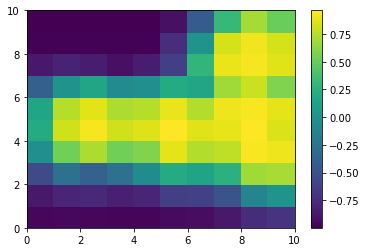

 52%|█████▏    | 261/500 [02:50<02:40,  1.49it/s]

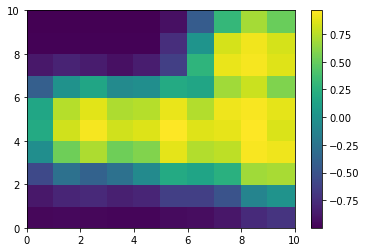

 52%|█████▏    | 262/500 [02:50<02:37,  1.51it/s]

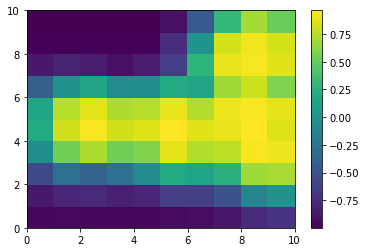

 53%|█████▎    | 263/500 [02:51<02:36,  1.52it/s]

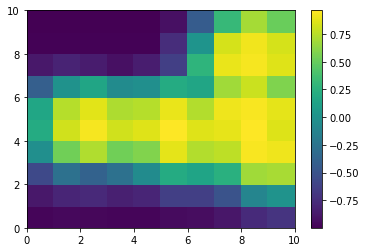

 53%|█████▎    | 264/500 [02:52<02:33,  1.53it/s]

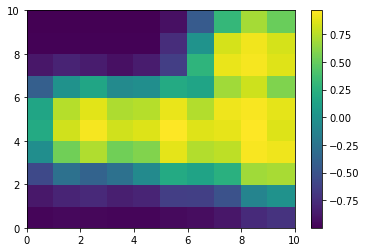

 53%|█████▎    | 265/500 [02:52<02:36,  1.50it/s]

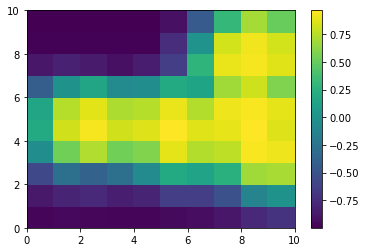

 53%|█████▎    | 266/500 [02:53<02:34,  1.51it/s]

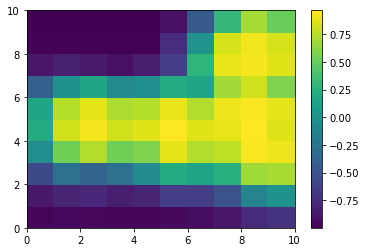

 53%|█████▎    | 267/500 [02:54<02:32,  1.53it/s]

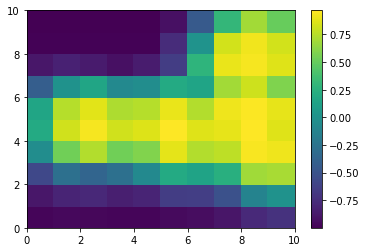

 54%|█████▎    | 268/500 [02:54<02:31,  1.53it/s]

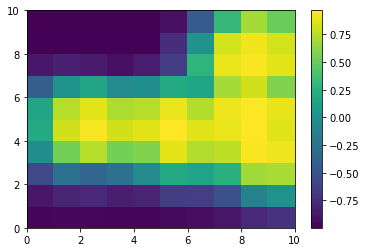

 54%|█████▍    | 269/500 [02:55<02:30,  1.53it/s]

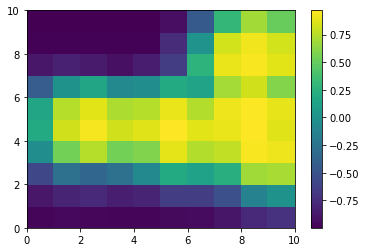

 54%|█████▍    | 270/500 [02:55<02:30,  1.53it/s]

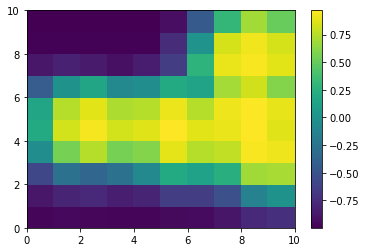

 54%|█████▍    | 271/500 [02:56<02:36,  1.47it/s]

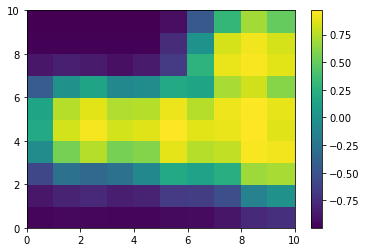

 54%|█████▍    | 272/500 [02:57<02:34,  1.48it/s]

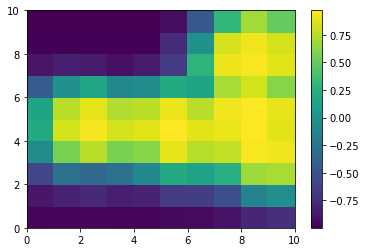

 55%|█████▍    | 273/500 [02:58<02:31,  1.49it/s]

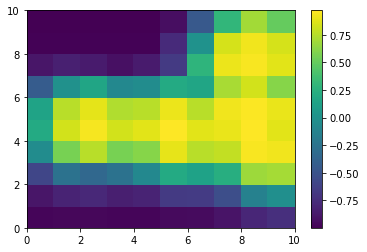

 55%|█████▍    | 274/500 [02:58<02:29,  1.51it/s]

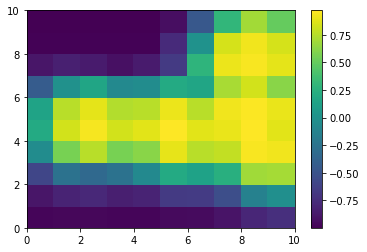

 55%|█████▌    | 275/500 [02:59<02:28,  1.51it/s]

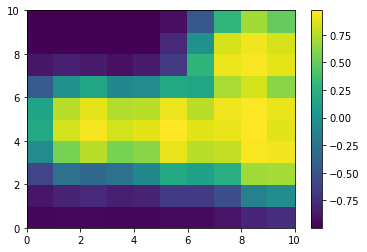

 55%|█████▌    | 276/500 [03:00<02:28,  1.51it/s]

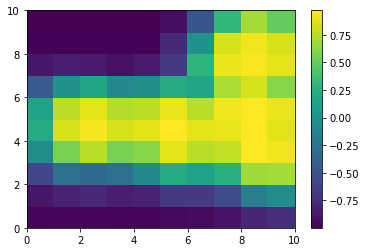

 55%|█████▌    | 277/500 [03:00<02:27,  1.52it/s]

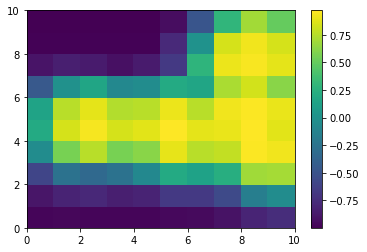

 56%|█████▌    | 278/500 [03:01<02:25,  1.52it/s]

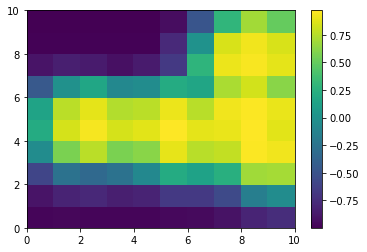

 56%|█████▌    | 279/500 [03:01<02:24,  1.53it/s]

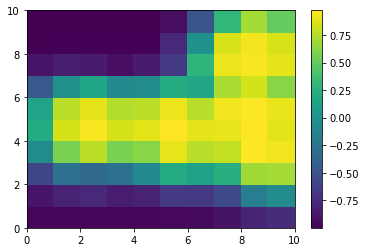

 56%|█████▌    | 280/500 [03:02<02:24,  1.52it/s]

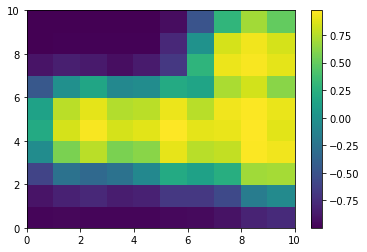

 56%|█████▌    | 281/500 [03:03<02:23,  1.53it/s]

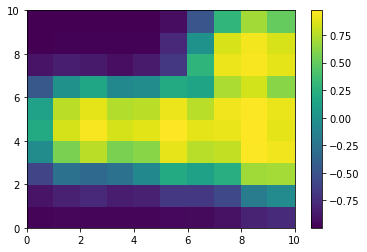

 56%|█████▋    | 282/500 [03:04<02:28,  1.46it/s]

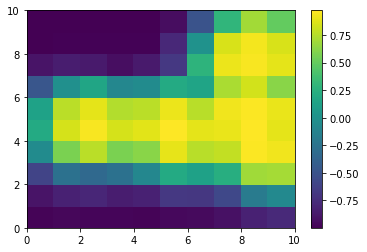

 57%|█████▋    | 283/500 [03:04<02:25,  1.49it/s]

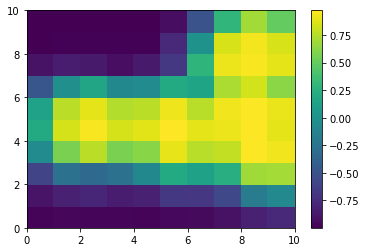

 57%|█████▋    | 284/500 [03:05<02:24,  1.49it/s]

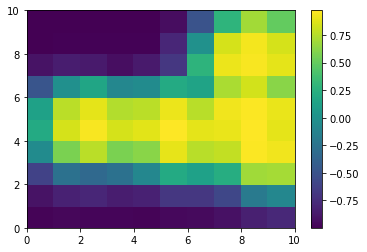

 57%|█████▋    | 285/500 [03:06<02:22,  1.51it/s]

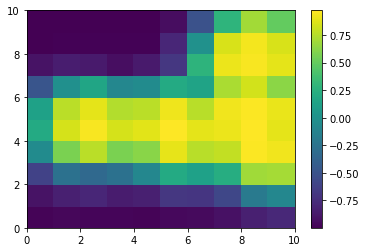

 57%|█████▋    | 286/500 [03:06<02:21,  1.51it/s]

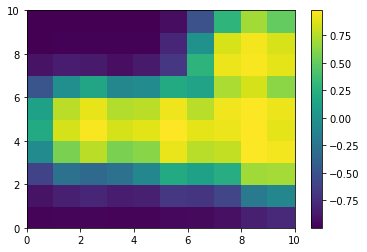

 57%|█████▋    | 287/500 [03:07<02:19,  1.53it/s]

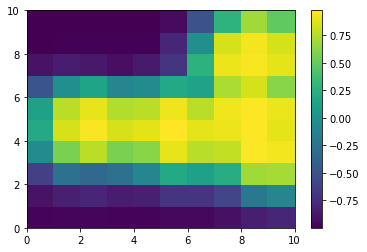

 58%|█████▊    | 288/500 [03:07<02:18,  1.53it/s]

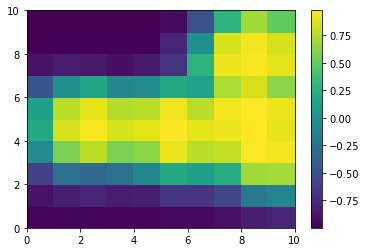

 58%|█████▊    | 289/500 [03:08<02:16,  1.55it/s]

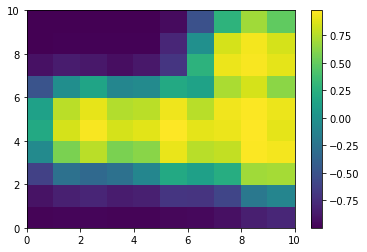

 58%|█████▊    | 290/500 [03:09<02:15,  1.54it/s]

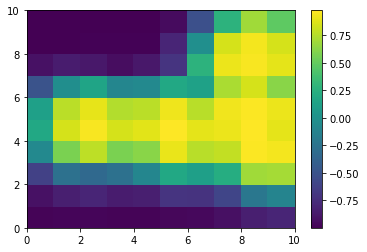

 58%|█████▊    | 291/500 [03:09<02:14,  1.55it/s]

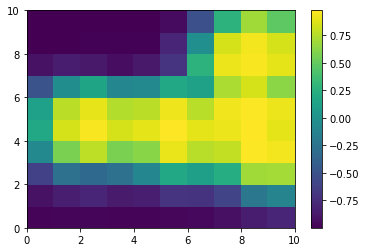

 58%|█████▊    | 292/500 [03:10<02:14,  1.55it/s]

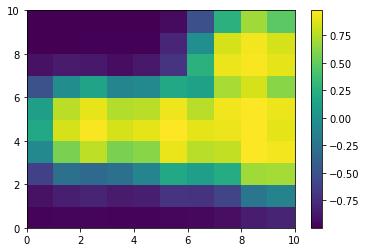

 59%|█████▊    | 293/500 [03:11<02:18,  1.49it/s]

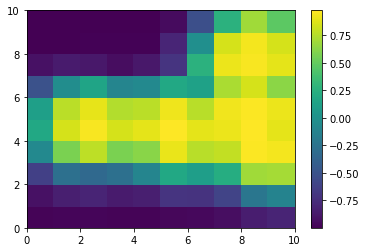

 59%|█████▉    | 294/500 [03:11<02:17,  1.49it/s]

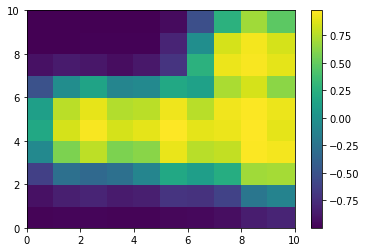

 59%|█████▉    | 295/500 [03:12<02:15,  1.52it/s]

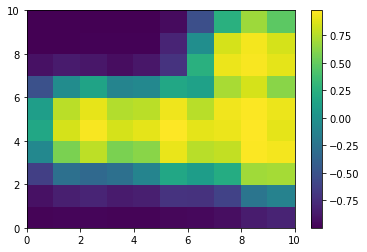

 59%|█████▉    | 296/500 [03:13<02:14,  1.52it/s]

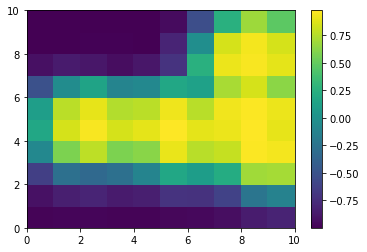

 59%|█████▉    | 297/500 [03:13<02:14,  1.51it/s]

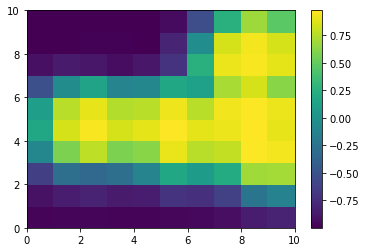

 60%|█████▉    | 298/500 [03:14<02:12,  1.53it/s]

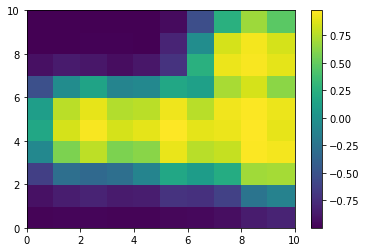

 60%|█████▉    | 299/500 [03:15<02:13,  1.51it/s]

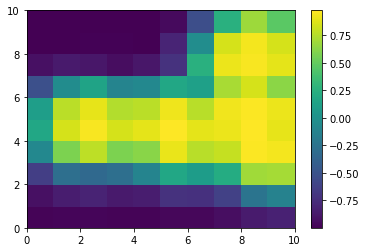

 60%|██████    | 300/500 [03:15<02:13,  1.50it/s]

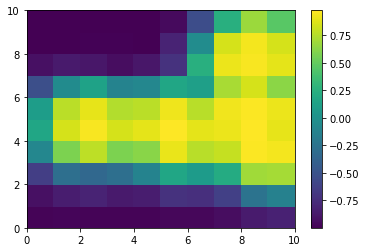

 60%|██████    | 301/500 [03:16<02:11,  1.51it/s]

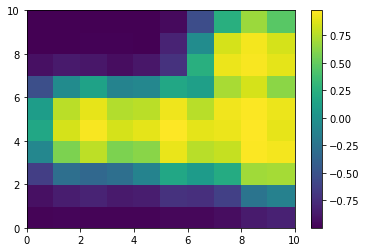

 60%|██████    | 302/500 [03:17<02:11,  1.51it/s]

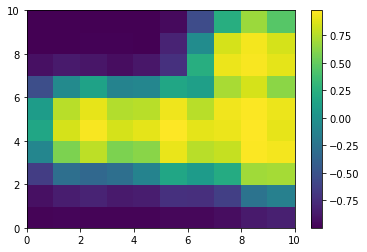

 61%|██████    | 303/500 [03:17<02:09,  1.52it/s]

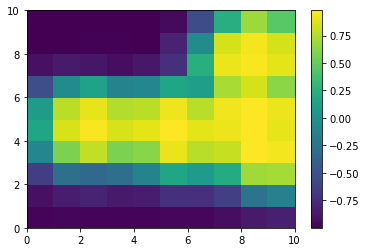

 61%|██████    | 304/500 [03:18<02:14,  1.46it/s]

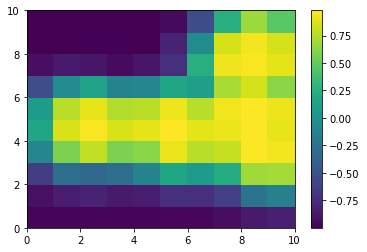

 61%|██████    | 305/500 [03:19<02:12,  1.47it/s]

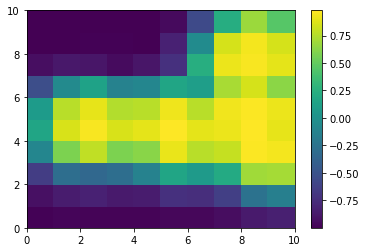

 61%|██████    | 306/500 [03:19<02:11,  1.48it/s]

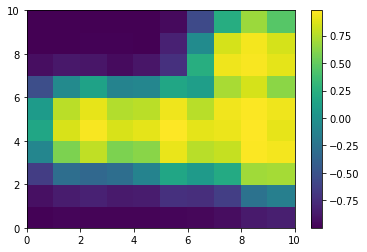

 61%|██████▏   | 307/500 [03:20<02:09,  1.49it/s]

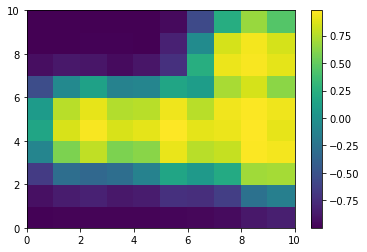

 62%|██████▏   | 308/500 [03:21<02:08,  1.49it/s]

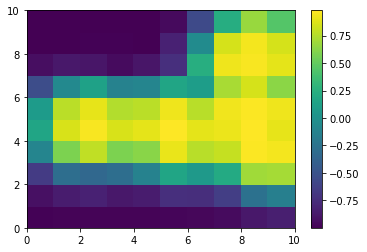

 62%|██████▏   | 309/500 [03:21<02:07,  1.50it/s]

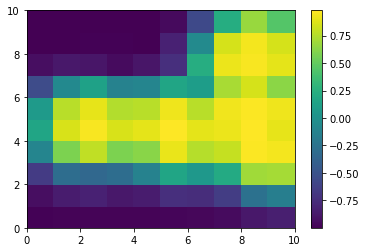

 62%|██████▏   | 310/500 [03:22<02:06,  1.51it/s]

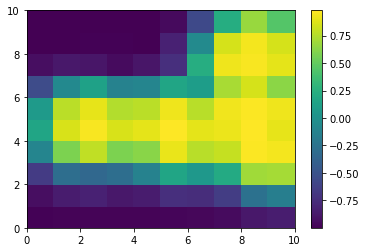

 62%|██████▏   | 311/500 [03:23<02:05,  1.50it/s]

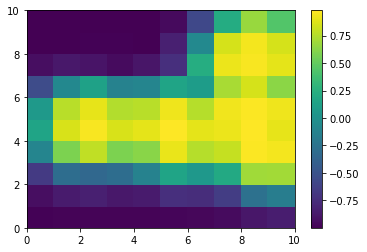

 62%|██████▏   | 312/500 [03:23<02:03,  1.52it/s]

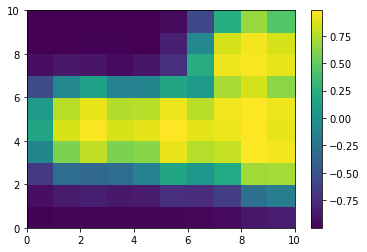

 63%|██████▎   | 313/500 [03:24<02:03,  1.51it/s]

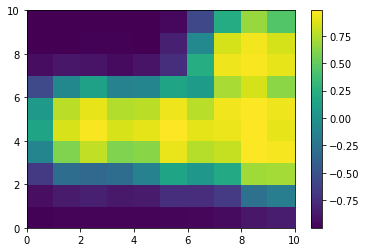

 63%|██████▎   | 314/500 [03:25<02:03,  1.51it/s]

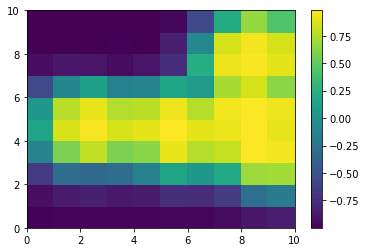

 63%|██████▎   | 315/500 [03:25<02:09,  1.43it/s]

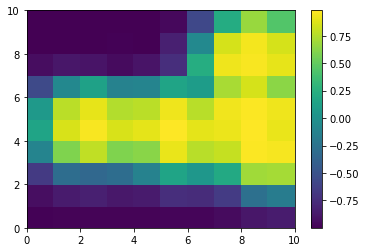

 63%|██████▎   | 316/500 [03:26<02:06,  1.45it/s]

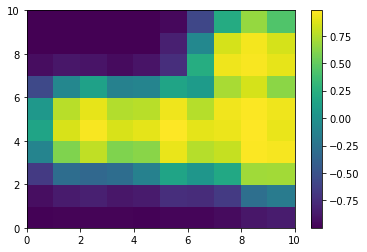

 63%|██████▎   | 317/500 [03:27<02:04,  1.47it/s]

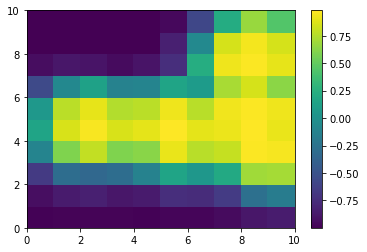

 64%|██████▎   | 318/500 [03:27<02:02,  1.48it/s]

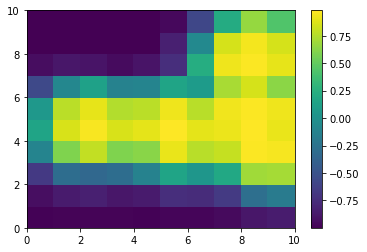

 64%|██████▍   | 319/500 [03:28<02:01,  1.49it/s]

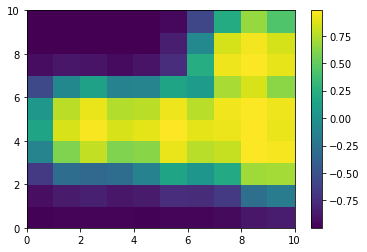

 64%|██████▍   | 320/500 [03:29<02:00,  1.49it/s]

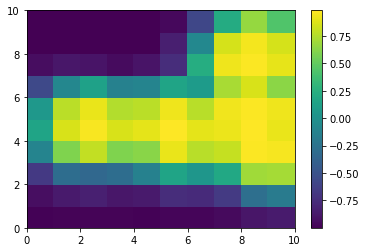

 64%|██████▍   | 321/500 [03:29<01:59,  1.50it/s]

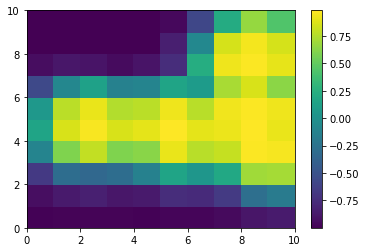

 64%|██████▍   | 322/500 [03:30<01:58,  1.50it/s]

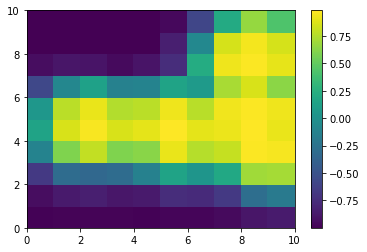

 65%|██████▍   | 323/500 [03:31<01:58,  1.50it/s]

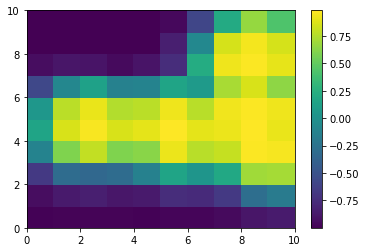

 65%|██████▍   | 324/500 [03:31<01:56,  1.51it/s]

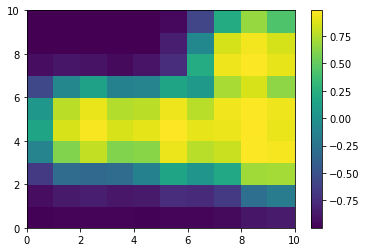

 65%|██████▌   | 325/500 [03:32<01:56,  1.50it/s]

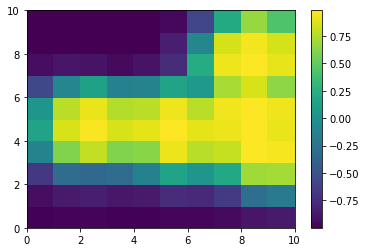

 65%|██████▌   | 326/500 [03:33<01:59,  1.45it/s]

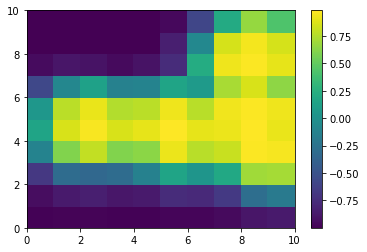

 65%|██████▌   | 327/500 [03:34<01:57,  1.47it/s]

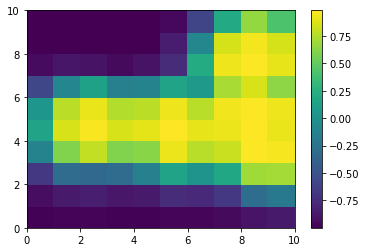

 66%|██████▌   | 328/500 [03:34<01:55,  1.49it/s]

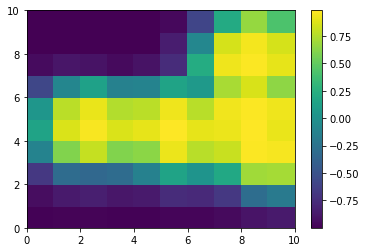

 66%|██████▌   | 329/500 [03:35<01:54,  1.50it/s]

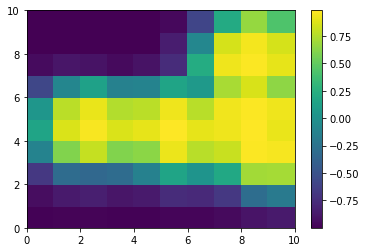

 66%|██████▌   | 330/500 [03:35<01:52,  1.51it/s]

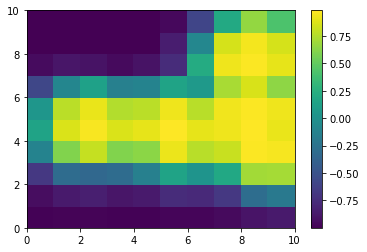

 66%|██████▌   | 331/500 [03:36<01:51,  1.51it/s]

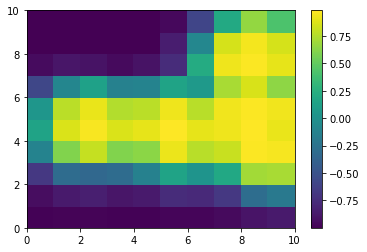

 66%|██████▋   | 332/500 [03:37<01:51,  1.50it/s]

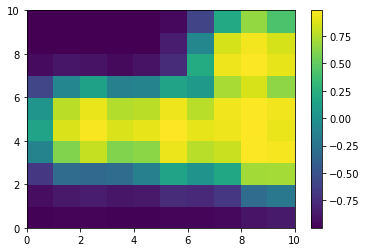

 67%|██████▋   | 333/500 [03:37<01:50,  1.51it/s]

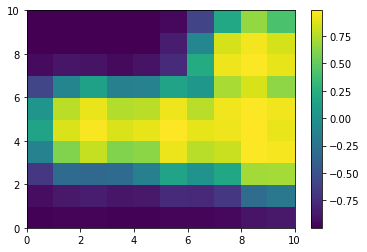

 67%|██████▋   | 334/500 [03:38<01:49,  1.52it/s]

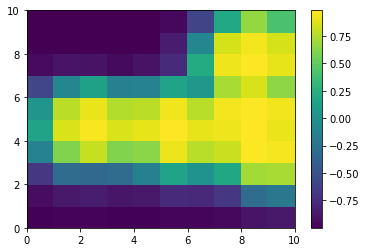

 67%|██████▋   | 335/500 [03:39<01:48,  1.52it/s]

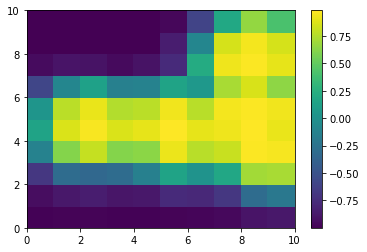

 67%|██████▋   | 336/500 [03:39<01:48,  1.52it/s]

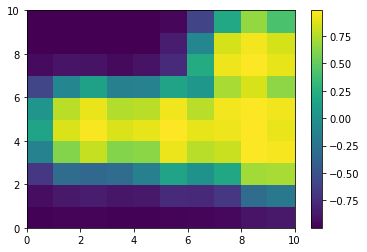

 67%|██████▋   | 337/500 [03:40<01:51,  1.46it/s]

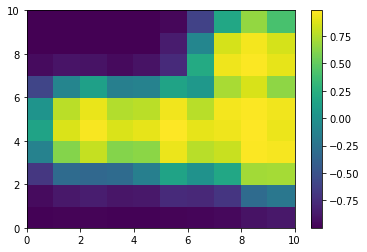

 68%|██████▊   | 338/500 [03:41<01:49,  1.47it/s]

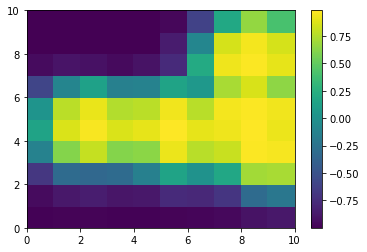

 68%|██████▊   | 339/500 [03:42<01:47,  1.49it/s]

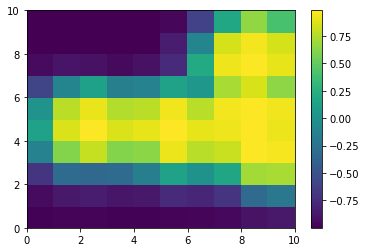

 68%|██████▊   | 340/500 [03:42<01:47,  1.49it/s]

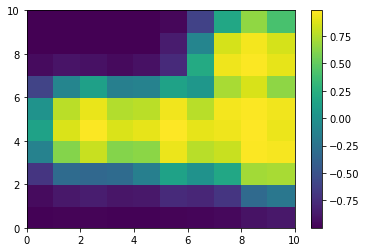

 68%|██████▊   | 341/500 [03:43<01:46,  1.50it/s]

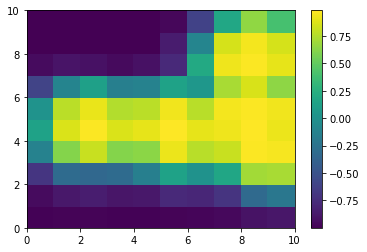

 68%|██████▊   | 342/500 [03:43<01:44,  1.51it/s]

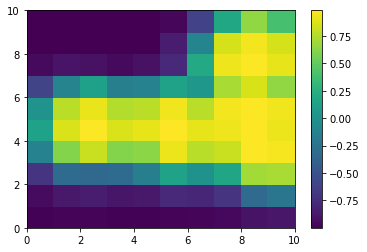

 69%|██████▊   | 343/500 [03:44<01:44,  1.51it/s]

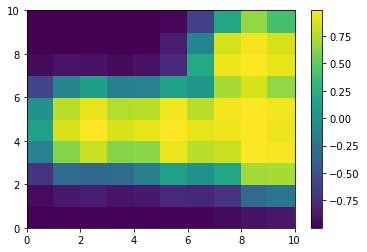

 69%|██████▉   | 344/500 [03:45<01:43,  1.51it/s]

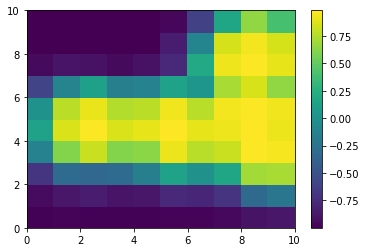

 69%|██████▉   | 345/500 [03:45<01:42,  1.52it/s]

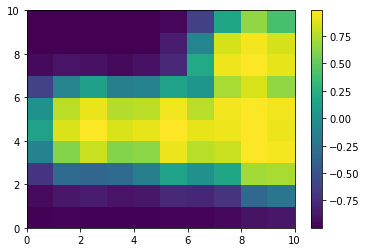

 69%|██████▉   | 346/500 [03:46<01:42,  1.50it/s]

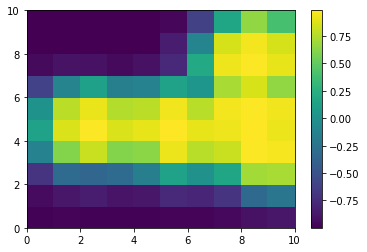

 69%|██████▉   | 347/500 [03:47<01:41,  1.51it/s]

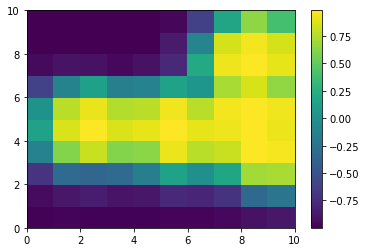

 70%|██████▉   | 348/500 [03:48<01:45,  1.45it/s]

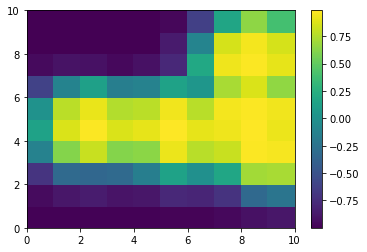

 70%|██████▉   | 349/500 [03:48<01:43,  1.46it/s]

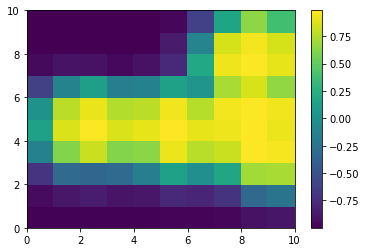

 70%|███████   | 350/500 [03:49<01:41,  1.48it/s]

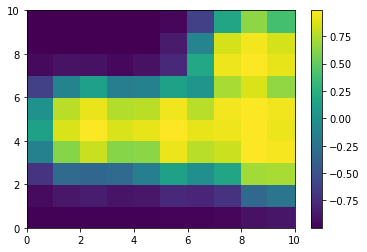

 70%|███████   | 351/500 [03:50<01:40,  1.49it/s]

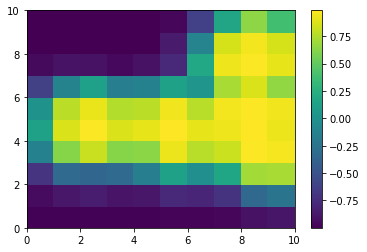

 70%|███████   | 352/500 [03:50<01:40,  1.47it/s]

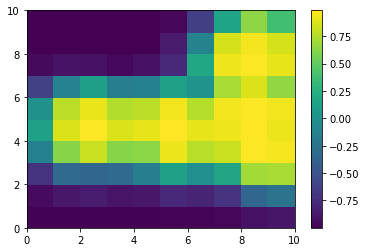

 71%|███████   | 353/500 [03:51<01:39,  1.47it/s]

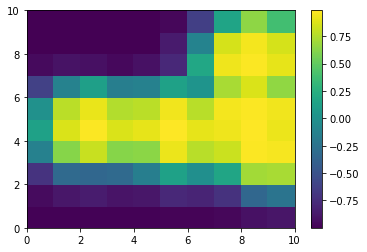

 71%|███████   | 354/500 [03:52<01:59,  1.22it/s]

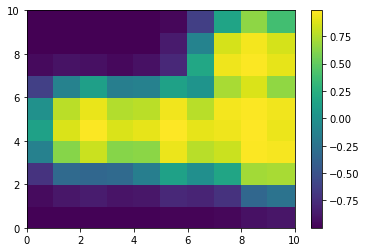

 71%|███████   | 355/500 [03:53<02:13,  1.08it/s]

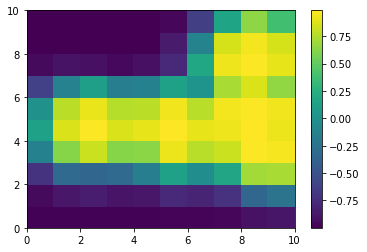

 71%|███████   | 356/500 [03:54<02:18,  1.04it/s]

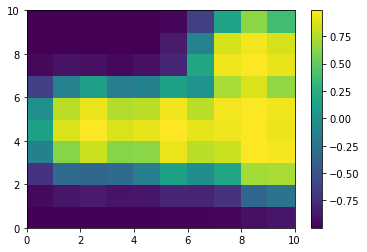

 71%|███████▏  | 357/500 [03:55<02:03,  1.16it/s]

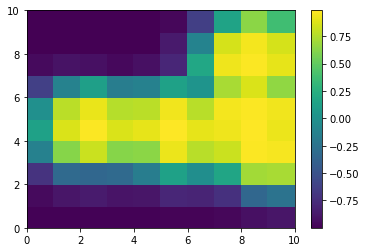

 72%|███████▏  | 358/500 [03:56<01:54,  1.24it/s]

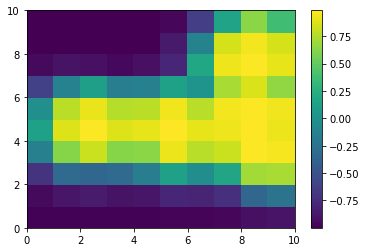

 72%|███████▏  | 359/500 [03:56<01:51,  1.26it/s]

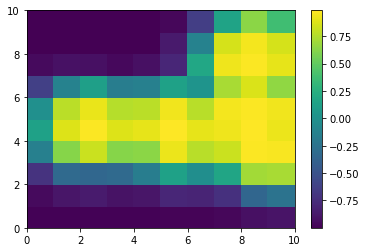

 72%|███████▏  | 360/500 [03:57<01:44,  1.34it/s]

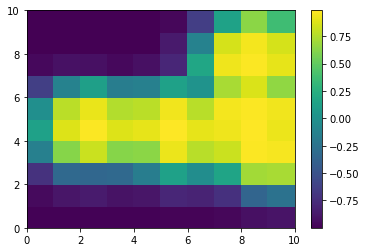

 72%|███████▏  | 361/500 [03:58<01:40,  1.38it/s]

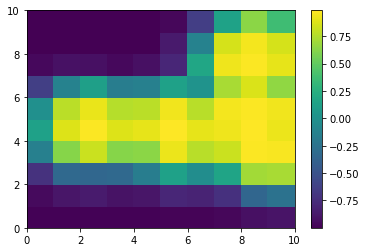

 72%|███████▏  | 362/500 [03:58<01:37,  1.42it/s]

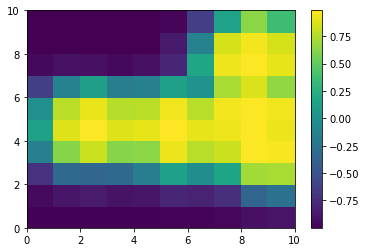

 73%|███████▎  | 363/500 [03:59<01:34,  1.45it/s]

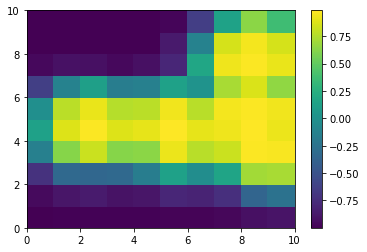

 73%|███████▎  | 364/500 [04:00<01:32,  1.47it/s]

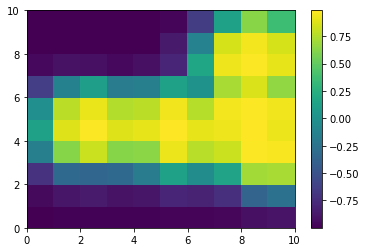

 73%|███████▎  | 365/500 [04:00<01:31,  1.48it/s]

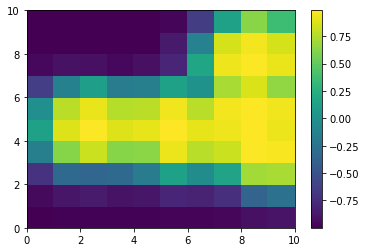

 73%|███████▎  | 366/500 [04:01<01:29,  1.49it/s]

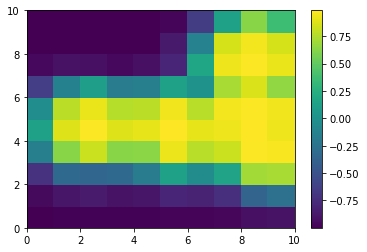

 73%|███████▎  | 367/500 [04:02<01:29,  1.49it/s]

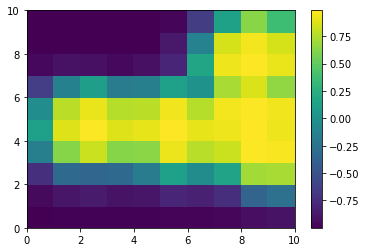

 74%|███████▎  | 368/500 [04:02<01:27,  1.50it/s]

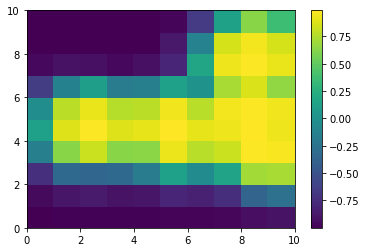

 74%|███████▍  | 369/500 [04:03<01:26,  1.51it/s]

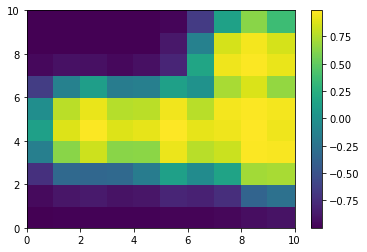

 74%|███████▍  | 370/500 [04:04<01:29,  1.45it/s]

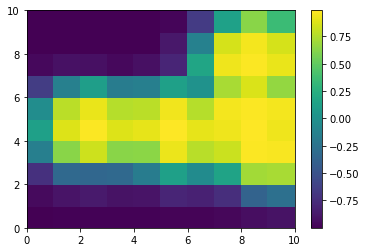

 74%|███████▍  | 371/500 [04:04<01:28,  1.46it/s]

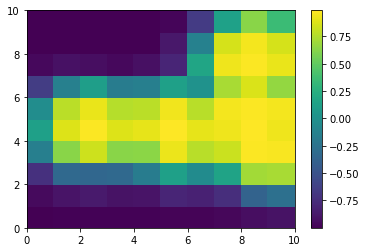

 74%|███████▍  | 372/500 [04:05<01:26,  1.48it/s]

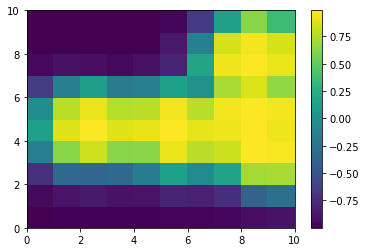

 75%|███████▍  | 373/500 [04:06<01:25,  1.49it/s]

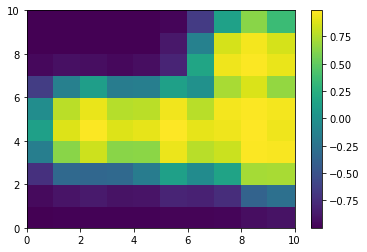

 75%|███████▍  | 374/500 [04:06<01:24,  1.49it/s]

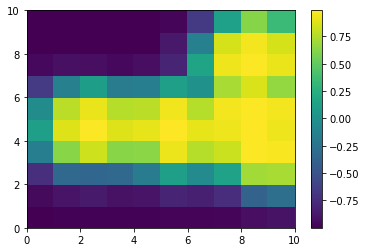

 75%|███████▌  | 375/500 [04:07<01:23,  1.50it/s]

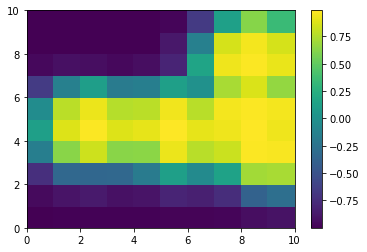

 75%|███████▌  | 376/500 [04:08<01:22,  1.51it/s]

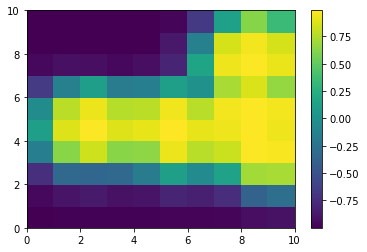

 75%|███████▌  | 377/500 [04:08<01:21,  1.51it/s]

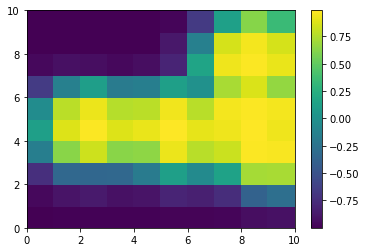

 76%|███████▌  | 378/500 [04:09<01:21,  1.50it/s]

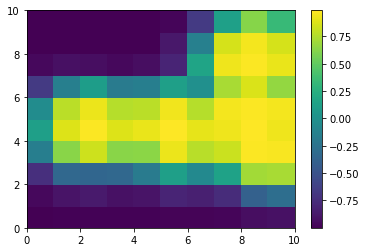

 76%|███████▌  | 379/500 [04:10<01:20,  1.51it/s]

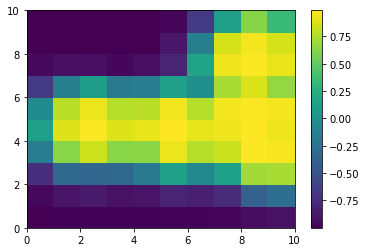

 76%|███████▌  | 380/500 [04:10<01:20,  1.50it/s]

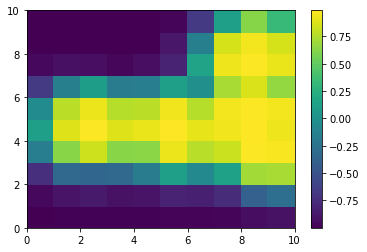

 76%|███████▌  | 381/500 [04:11<01:22,  1.44it/s]

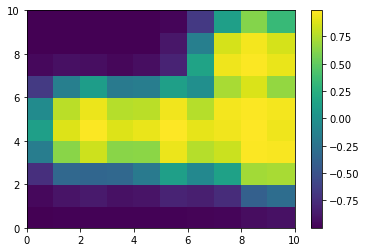

 76%|███████▋  | 382/500 [04:12<01:20,  1.46it/s]

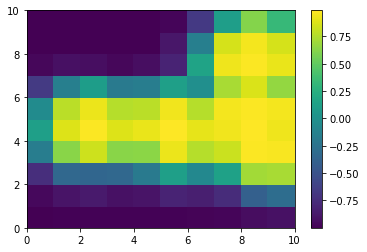

 77%|███████▋  | 383/500 [04:12<01:19,  1.48it/s]

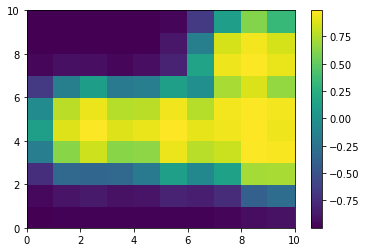

 77%|███████▋  | 384/500 [04:13<01:17,  1.49it/s]

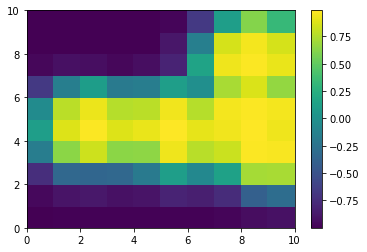

 77%|███████▋  | 385/500 [04:14<01:19,  1.45it/s]

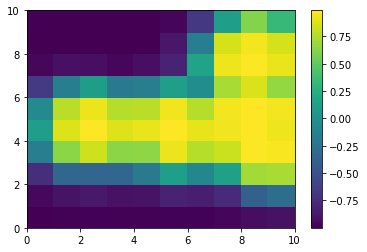

 77%|███████▋  | 386/500 [04:15<01:25,  1.33it/s]

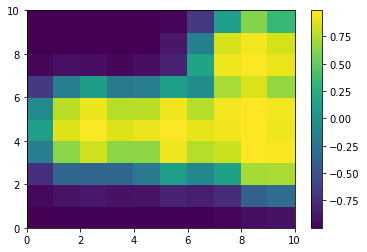

 77%|███████▋  | 387/500 [04:16<01:29,  1.26it/s]

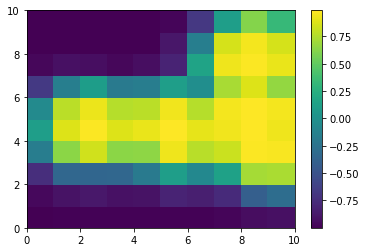

 78%|███████▊  | 388/500 [04:16<01:24,  1.33it/s]

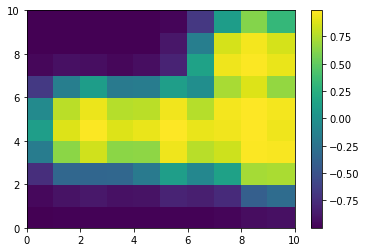

 78%|███████▊  | 389/500 [04:17<01:20,  1.38it/s]

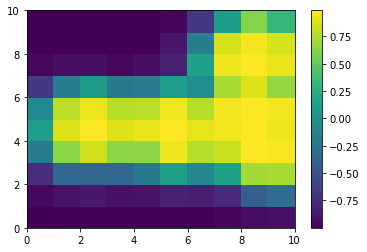

 78%|███████▊  | 390/500 [04:18<01:17,  1.42it/s]

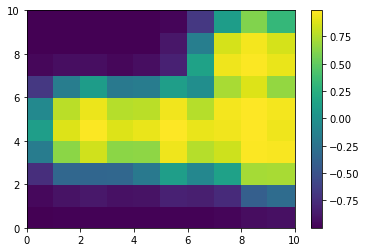

 78%|███████▊  | 391/500 [04:18<01:15,  1.43it/s]

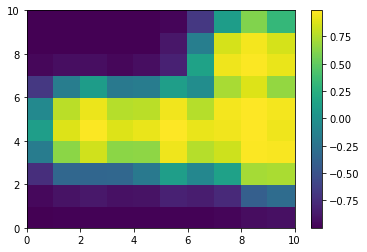

 78%|███████▊  | 392/500 [04:19<01:17,  1.39it/s]

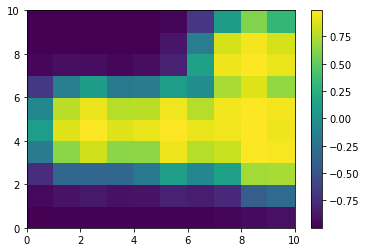

 79%|███████▊  | 393/500 [04:20<01:15,  1.42it/s]

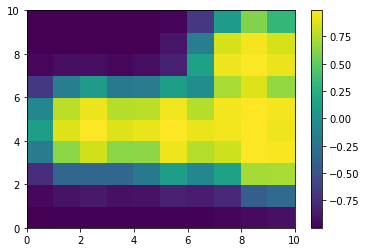

 79%|███████▉  | 394/500 [04:20<01:13,  1.45it/s]

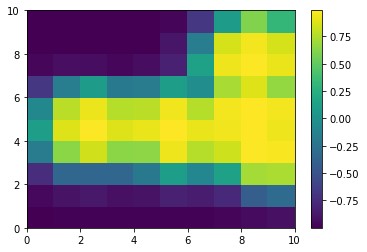

 79%|███████▉  | 395/500 [04:21<01:11,  1.47it/s]

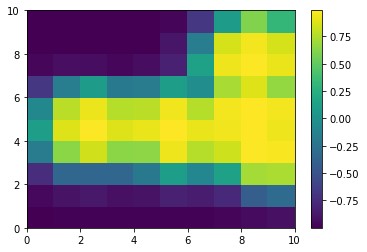

 79%|███████▉  | 396/500 [04:22<01:10,  1.47it/s]

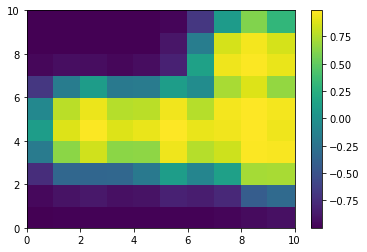

 79%|███████▉  | 397/500 [04:22<01:09,  1.47it/s]

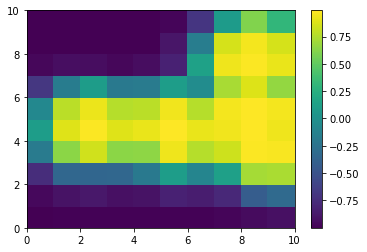

 80%|███████▉  | 398/500 [04:23<01:08,  1.49it/s]

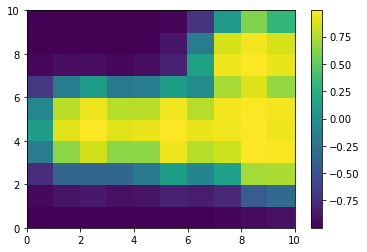

 80%|███████▉  | 399/500 [04:24<01:07,  1.49it/s]

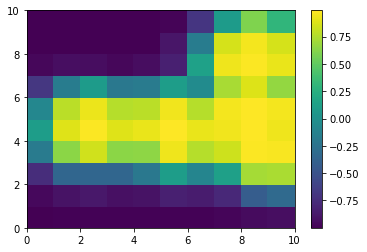

 80%|████████  | 400/500 [04:24<01:06,  1.51it/s]

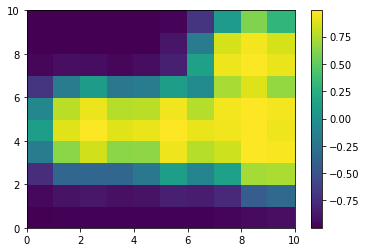

 80%|████████  | 401/500 [04:25<01:05,  1.51it/s]

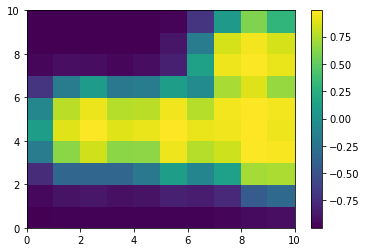

 80%|████████  | 402/500 [04:26<01:04,  1.51it/s]

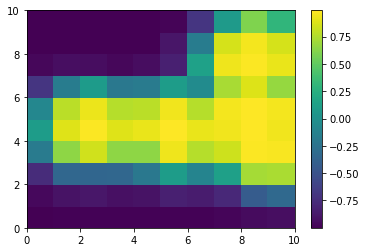

 81%|████████  | 403/500 [04:26<01:06,  1.45it/s]

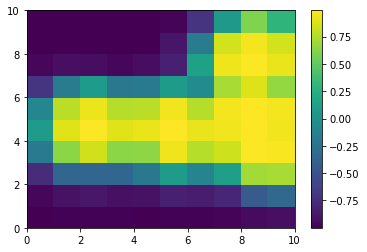

 81%|████████  | 404/500 [04:27<01:05,  1.46it/s]

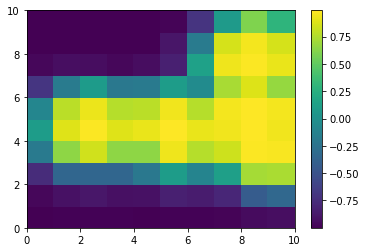

 81%|████████  | 405/500 [04:28<01:04,  1.48it/s]

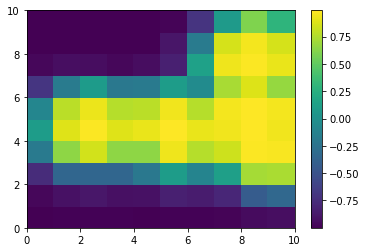

 81%|████████  | 406/500 [04:28<01:03,  1.48it/s]

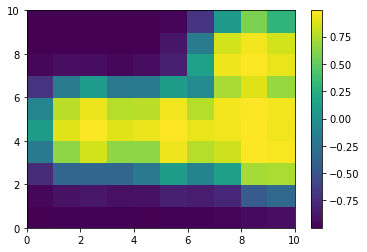

 81%|████████▏ | 407/500 [04:29<01:02,  1.48it/s]

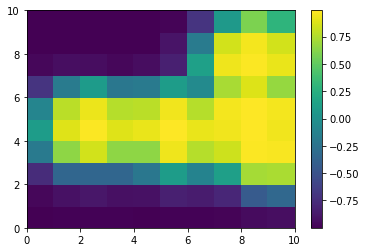

 82%|████████▏ | 408/500 [04:30<01:01,  1.49it/s]

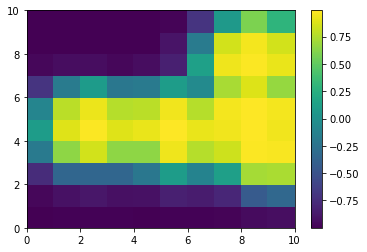

 82%|████████▏ | 409/500 [04:30<01:01,  1.49it/s]

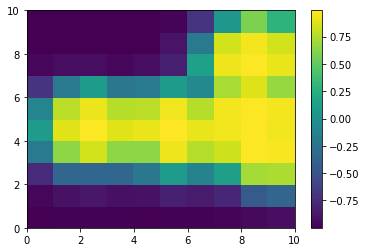

 82%|████████▏ | 410/500 [04:31<01:00,  1.49it/s]

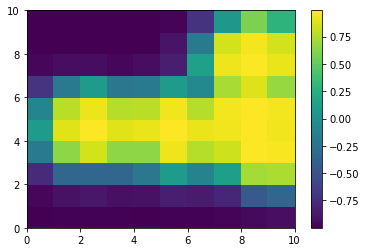

 82%|████████▏ | 411/500 [04:32<00:59,  1.49it/s]

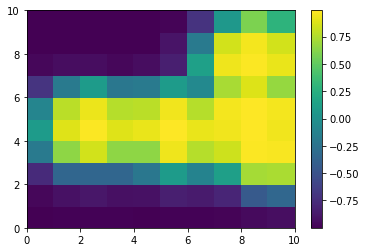

 82%|████████▏ | 412/500 [04:32<00:58,  1.50it/s]

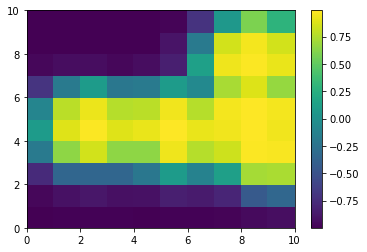

 83%|████████▎ | 413/500 [04:33<00:58,  1.49it/s]

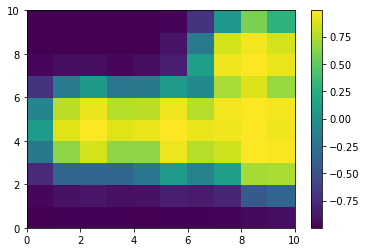

 83%|████████▎ | 414/500 [04:34<00:59,  1.45it/s]

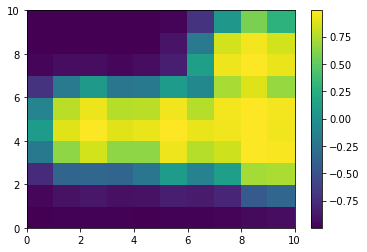

 83%|████████▎ | 415/500 [04:34<00:57,  1.47it/s]

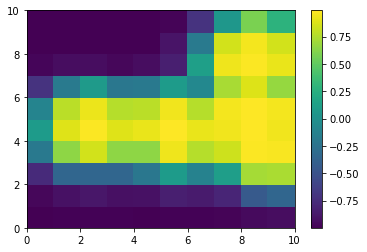

 83%|████████▎ | 416/500 [04:35<00:56,  1.48it/s]

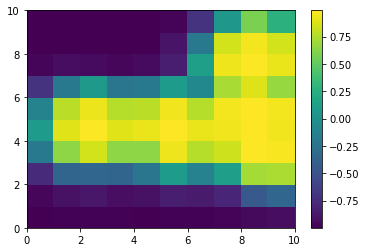

 83%|████████▎ | 417/500 [04:36<00:55,  1.49it/s]

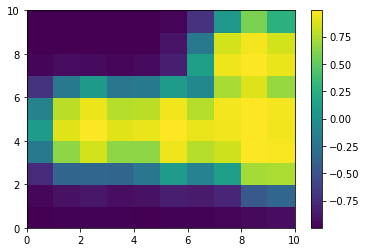

 84%|████████▎ | 418/500 [04:36<00:54,  1.50it/s]

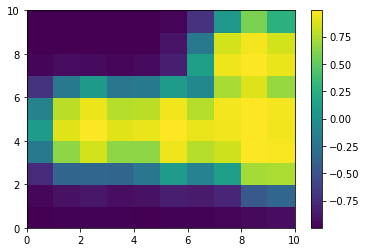

 84%|████████▍ | 419/500 [04:37<00:54,  1.49it/s]

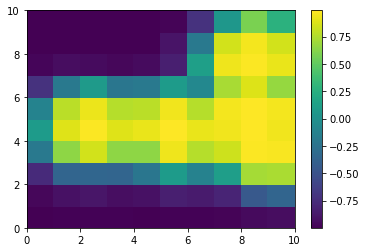

 84%|████████▍ | 420/500 [04:38<00:53,  1.50it/s]

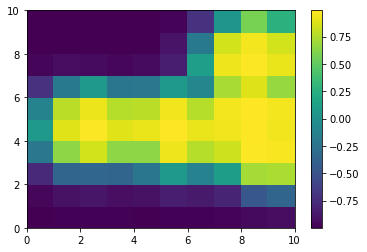

 84%|████████▍ | 421/500 [04:38<00:52,  1.50it/s]

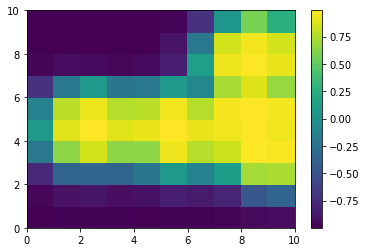

 84%|████████▍ | 422/500 [04:39<00:51,  1.50it/s]

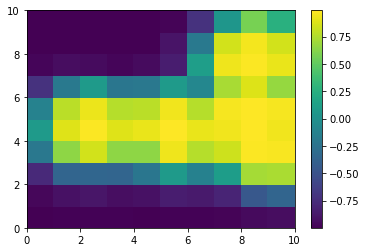

 85%|████████▍ | 423/500 [04:40<00:51,  1.51it/s]

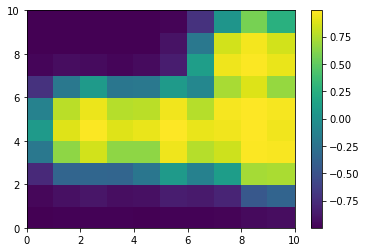

 85%|████████▍ | 424/500 [04:40<00:50,  1.50it/s]

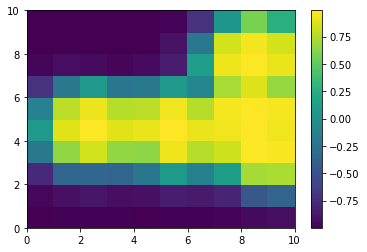

 85%|████████▌ | 425/500 [04:41<00:52,  1.44it/s]

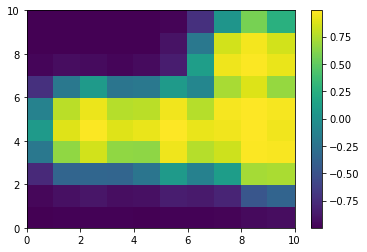

 85%|████████▌ | 426/500 [04:42<00:50,  1.46it/s]

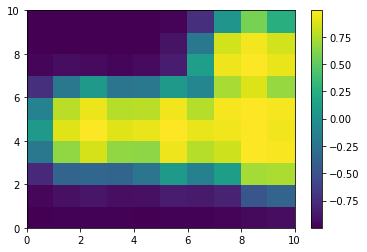

 85%|████████▌ | 427/500 [04:43<00:49,  1.47it/s]

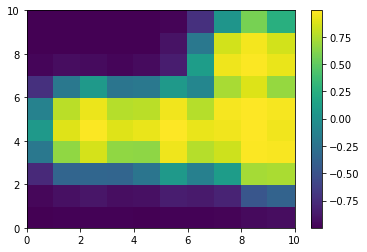

 86%|████████▌ | 428/500 [04:43<00:48,  1.47it/s]

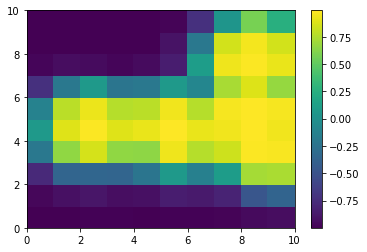

 86%|████████▌ | 429/500 [04:44<00:47,  1.49it/s]

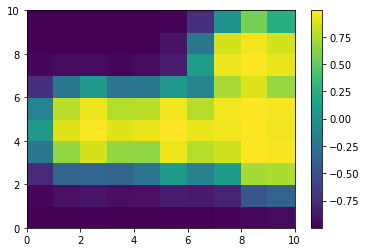

 86%|████████▌ | 430/500 [04:45<00:47,  1.48it/s]

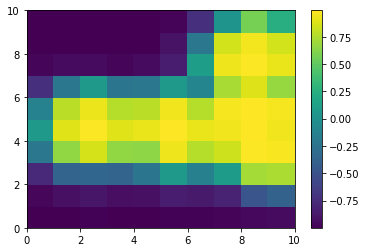

 86%|████████▌ | 431/500 [04:45<00:46,  1.48it/s]

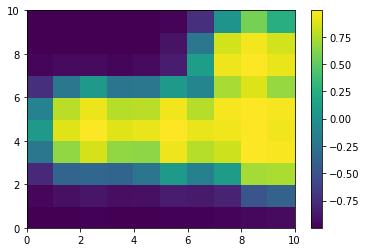

 86%|████████▋ | 432/500 [04:46<00:45,  1.48it/s]

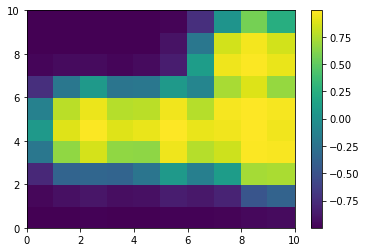

 87%|████████▋ | 433/500 [04:47<00:45,  1.48it/s]

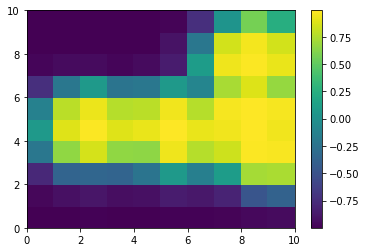

 87%|████████▋ | 434/500 [04:47<00:44,  1.48it/s]

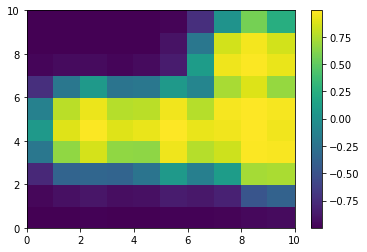

 87%|████████▋ | 435/500 [04:48<00:43,  1.49it/s]

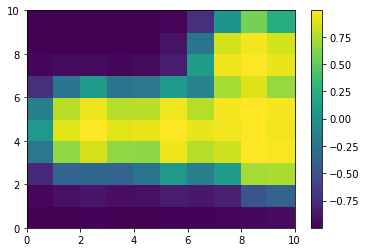

 87%|████████▋ | 436/500 [04:49<00:44,  1.43it/s]

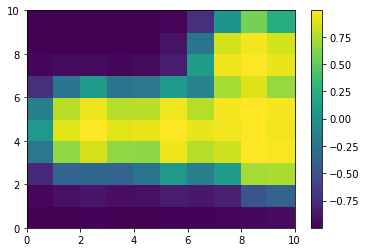

 87%|████████▋ | 437/500 [04:49<00:43,  1.44it/s]

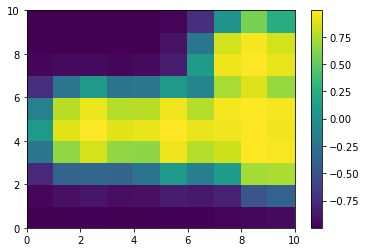

 88%|████████▊ | 438/500 [04:50<00:42,  1.46it/s]

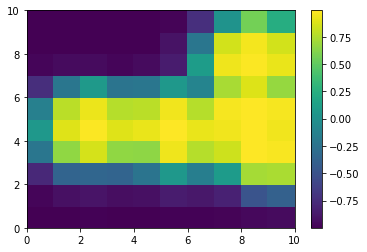

 88%|████████▊ | 439/500 [04:51<00:41,  1.46it/s]

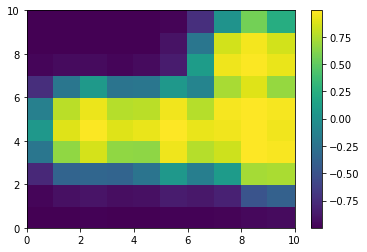

 88%|████████▊ | 440/500 [04:51<00:40,  1.47it/s]

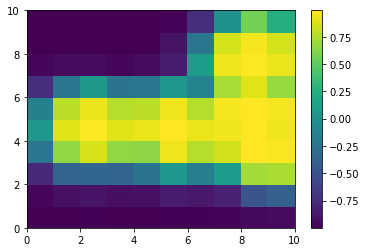

 88%|████████▊ | 441/500 [04:52<00:39,  1.49it/s]

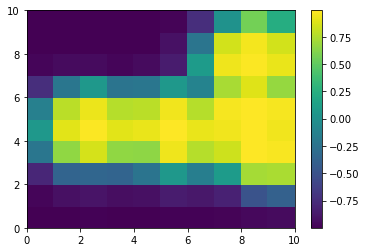

 88%|████████▊ | 442/500 [04:53<00:39,  1.48it/s]

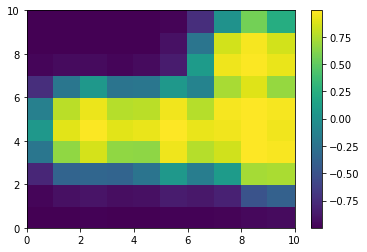

 89%|████████▊ | 443/500 [04:53<00:38,  1.49it/s]

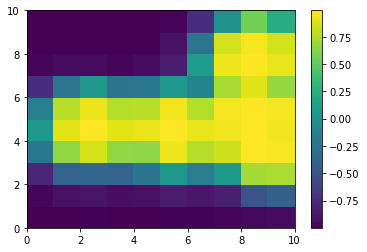

 89%|████████▉ | 444/500 [04:54<00:37,  1.50it/s]

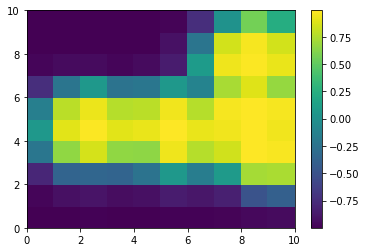

 89%|████████▉ | 445/500 [04:55<00:36,  1.50it/s]

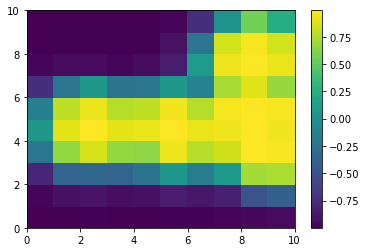

 89%|████████▉ | 446/500 [04:55<00:35,  1.51it/s]

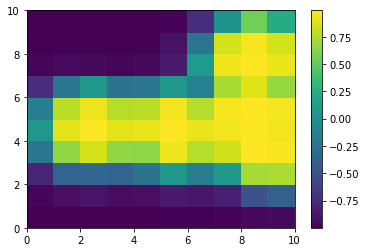

 89%|████████▉ | 447/500 [04:56<00:36,  1.45it/s]

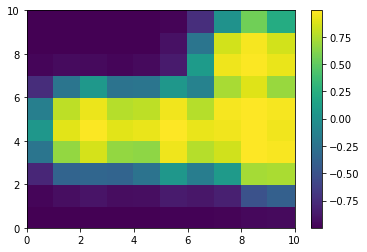

 90%|████████▉ | 448/500 [04:57<00:35,  1.47it/s]

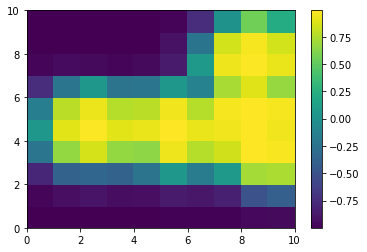

 90%|████████▉ | 449/500 [04:57<00:34,  1.48it/s]

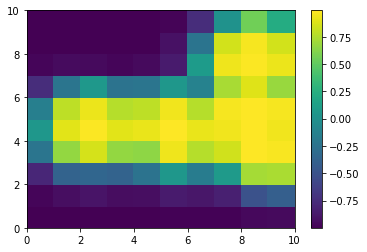

 90%|█████████ | 450/500 [04:58<00:33,  1.48it/s]

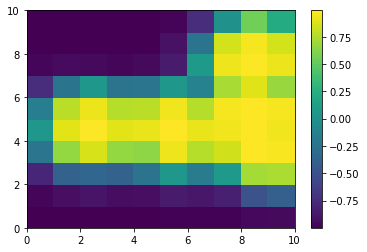

 90%|█████████ | 451/500 [04:59<00:33,  1.48it/s]

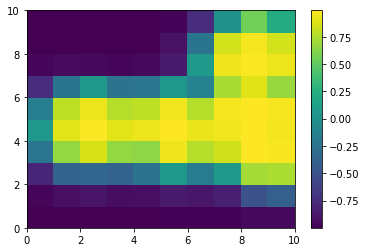

 90%|█████████ | 452/500 [04:59<00:32,  1.48it/s]

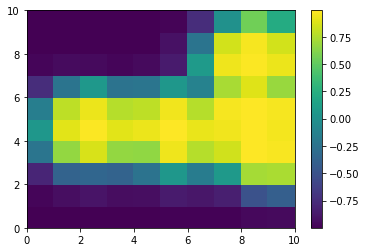

 91%|█████████ | 453/500 [05:00<00:31,  1.50it/s]

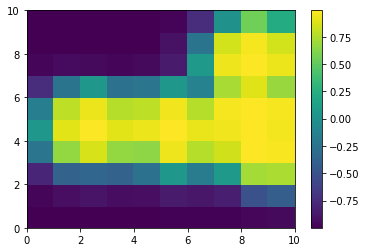

 91%|█████████ | 454/500 [05:01<00:30,  1.50it/s]

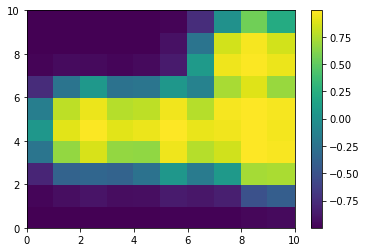

 91%|█████████ | 455/500 [05:01<00:29,  1.51it/s]

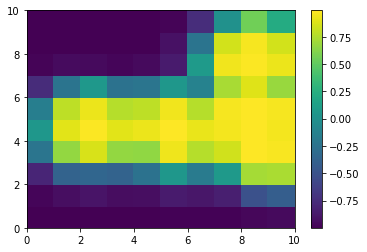

 91%|█████████ | 456/500 [05:02<00:28,  1.53it/s]

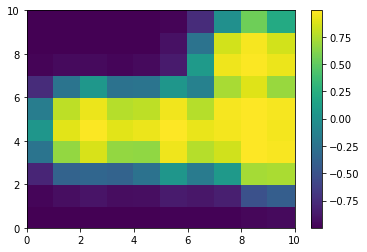

 91%|█████████▏| 457/500 [05:03<00:28,  1.51it/s]

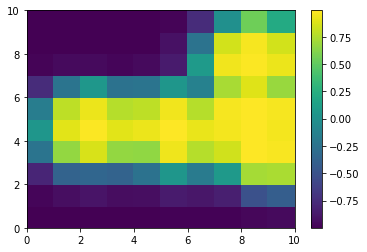

 92%|█████████▏| 458/500 [05:03<00:28,  1.46it/s]

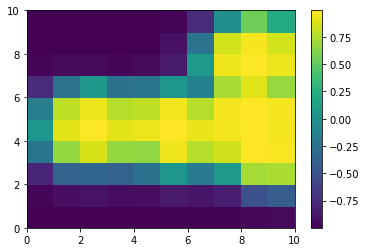

 92%|█████████▏| 459/500 [05:04<00:27,  1.47it/s]

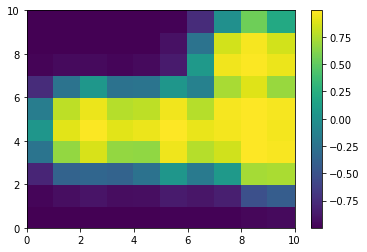

 92%|█████████▏| 460/500 [05:05<00:27,  1.47it/s]

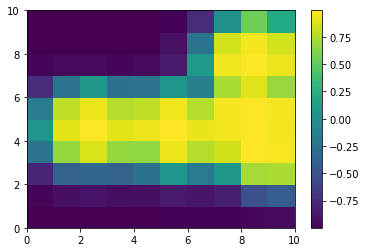

 92%|█████████▏| 461/500 [05:06<00:26,  1.48it/s]

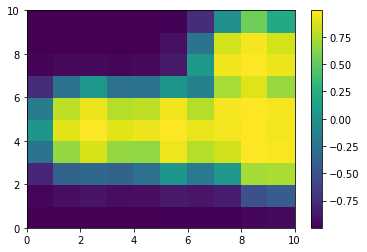

 92%|█████████▏| 462/500 [05:06<00:25,  1.49it/s]

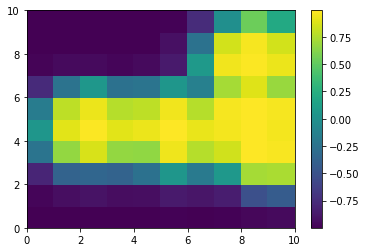

 93%|█████████▎| 463/500 [05:07<00:24,  1.50it/s]

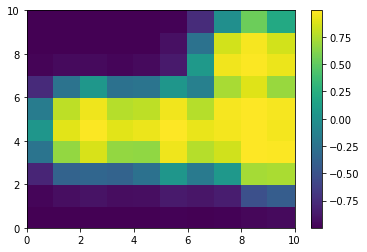

 93%|█████████▎| 464/500 [05:07<00:23,  1.50it/s]

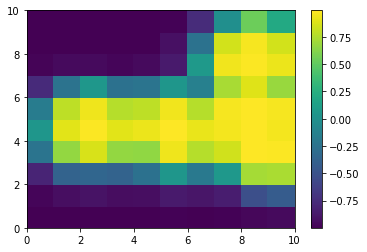

 93%|█████████▎| 465/500 [05:08<00:23,  1.49it/s]

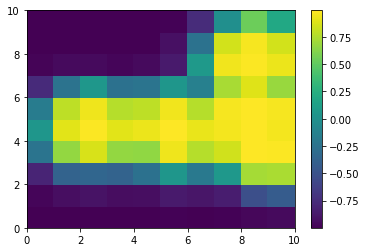

 93%|█████████▎| 466/500 [05:09<00:22,  1.49it/s]

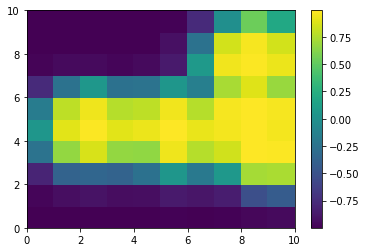

 93%|█████████▎| 467/500 [05:10<00:22,  1.50it/s]

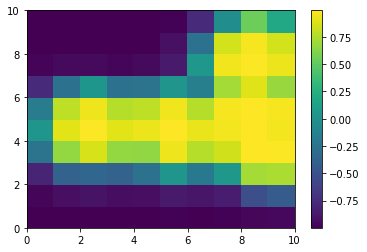

 94%|█████████▎| 468/500 [05:10<00:21,  1.51it/s]

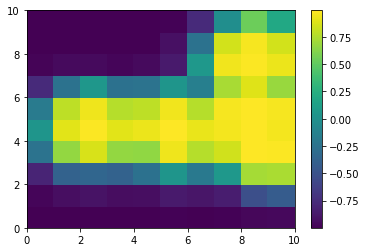

 94%|█████████▍| 469/500 [05:11<00:21,  1.46it/s]

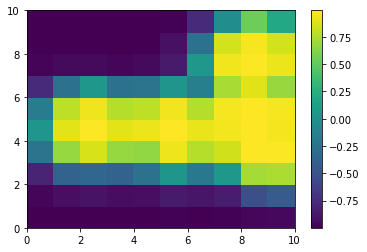

 94%|█████████▍| 470/500 [05:12<00:20,  1.48it/s]

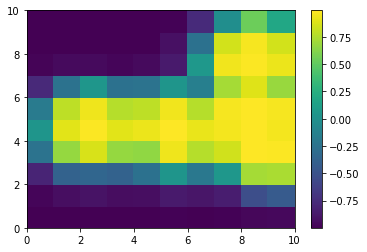

 94%|█████████▍| 471/500 [05:12<00:19,  1.48it/s]

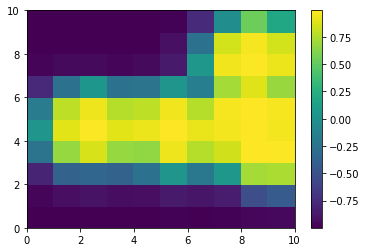

 94%|█████████▍| 472/500 [05:13<00:18,  1.48it/s]

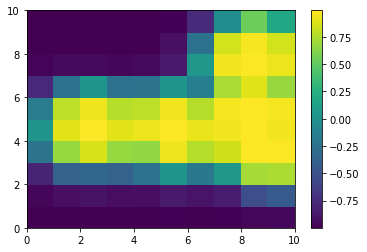

 95%|█████████▍| 473/500 [05:14<00:18,  1.49it/s]

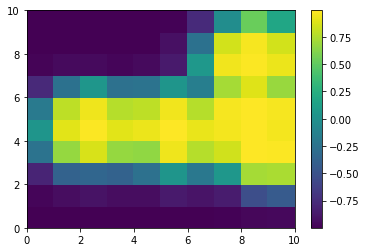

 95%|█████████▍| 474/500 [05:14<00:17,  1.47it/s]

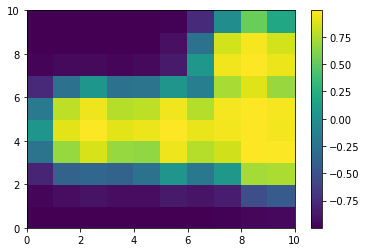

 95%|█████████▌| 475/500 [05:15<00:17,  1.47it/s]

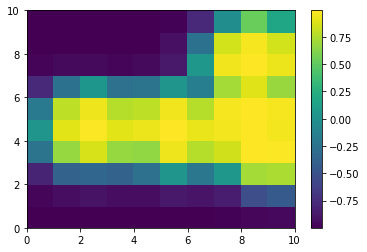

 95%|█████████▌| 476/500 [05:16<00:16,  1.47it/s]

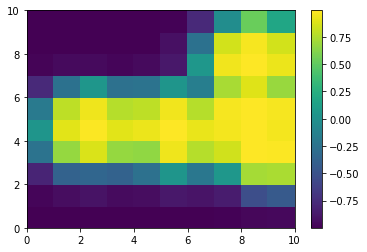

 95%|█████████▌| 477/500 [05:16<00:15,  1.48it/s]

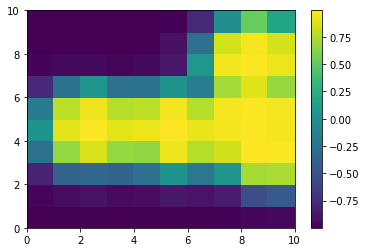

 96%|█████████▌| 478/500 [05:17<00:14,  1.48it/s]

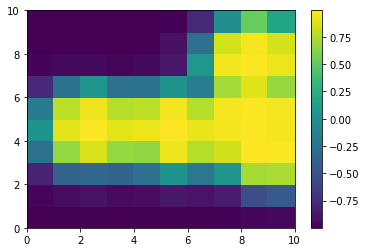

 96%|█████████▌| 479/500 [05:18<00:14,  1.49it/s]

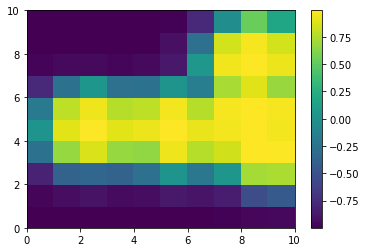

 96%|█████████▌| 480/500 [05:18<00:14,  1.42it/s]

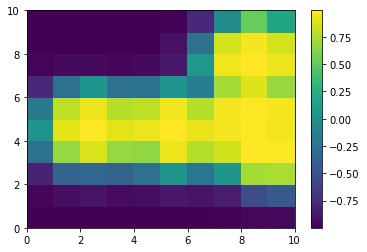

 96%|█████████▌| 481/500 [05:19<00:13,  1.45it/s]

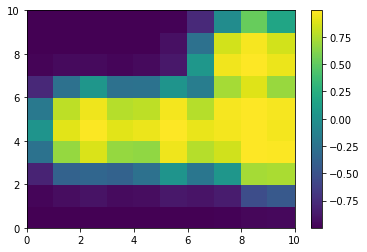

 96%|█████████▋| 482/500 [05:20<00:12,  1.45it/s]

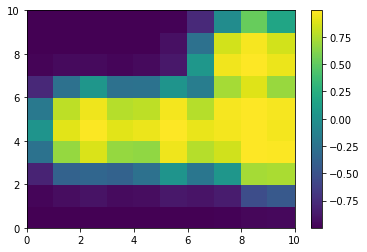

 97%|█████████▋| 483/500 [05:20<00:11,  1.47it/s]

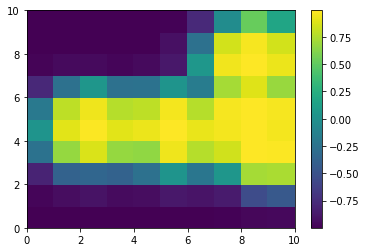

 97%|█████████▋| 484/500 [05:21<00:10,  1.48it/s]

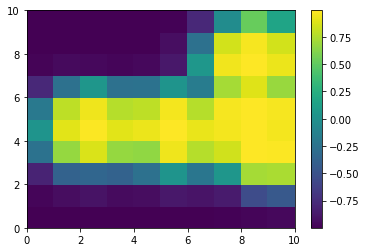

 97%|█████████▋| 485/500 [05:22<00:10,  1.49it/s]

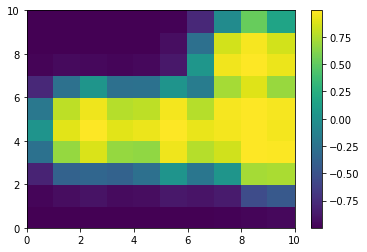

 97%|█████████▋| 486/500 [05:22<00:09,  1.48it/s]

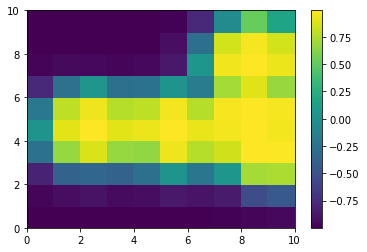

 97%|█████████▋| 487/500 [05:23<00:08,  1.48it/s]

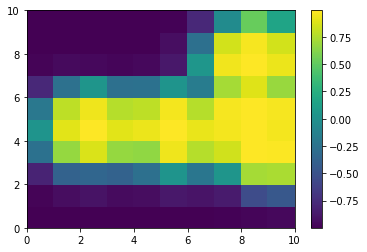

 98%|█████████▊| 488/500 [05:24<00:08,  1.49it/s]

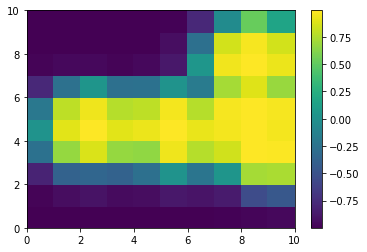

 98%|█████████▊| 489/500 [05:24<00:07,  1.49it/s]

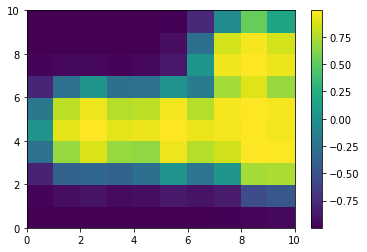

 98%|█████████▊| 490/500 [05:25<00:06,  1.49it/s]

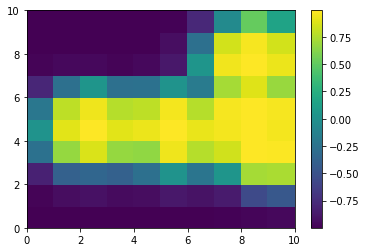

 98%|█████████▊| 491/500 [05:26<00:06,  1.45it/s]

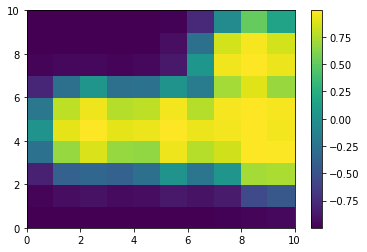

 98%|█████████▊| 492/500 [05:26<00:05,  1.47it/s]

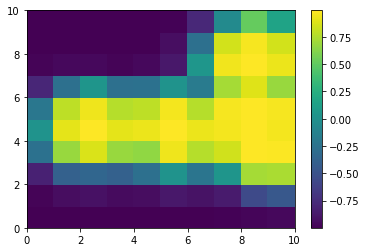

 99%|█████████▊| 493/500 [05:27<00:04,  1.48it/s]

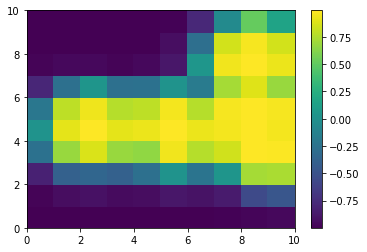

 99%|█████████▉| 494/500 [05:28<00:04,  1.49it/s]

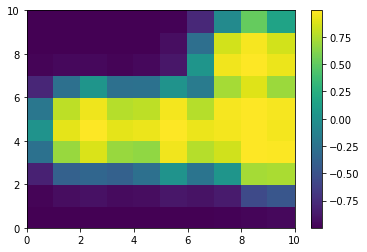

 99%|█████████▉| 495/500 [05:28<00:03,  1.50it/s]

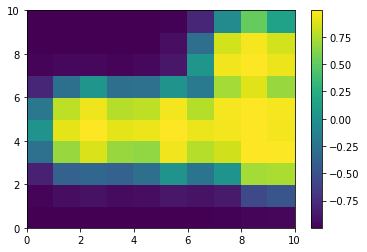

 99%|█████████▉| 496/500 [05:29<00:02,  1.50it/s]

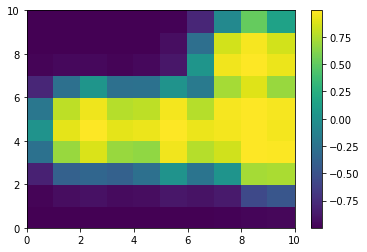

 99%|█████████▉| 497/500 [05:30<00:01,  1.51it/s]

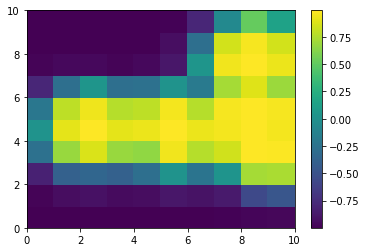

100%|█████████▉| 498/500 [05:30<00:01,  1.50it/s]

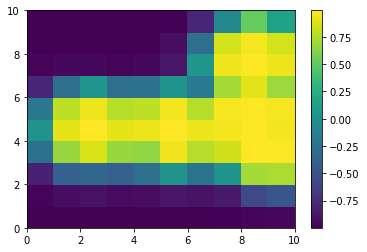

100%|█████████▉| 499/500 [05:31<00:00,  1.51it/s]

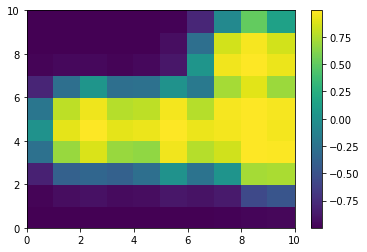

100%|██████████| 500/500 [05:32<00:00,  1.50it/s]


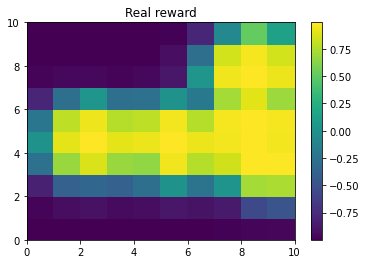

In [21]:
rewards = dme.train(n_epochs, plot=True).reshape(grid_size, grid_size)

plt.pcolor(rewards)
plt.colorbar()
plt.title("Real reward")
plt.show()

Record

In [23]:
from matplotlib.animation import FuncAnimation
from IPython import display

In [24]:
rews = dme.get_rewards()

In [ ]:
Figure = plt.figure()
ax = plt.subplot()

In [26]:
def AnimationFunction(frame):
    ax.pcolor(rews[frame].reshape(grid_size, grid_size))

In [27]:
anim_created = FuncAnimation(Figure, AnimationFunction, frames=len(rews), interval=25)

In [28]:
video = anim_created.to_html5_video()
html = display.HTML(video)
display.display(html)
 
# good practice to close the plt object.
plt.close()